Juan Andres Galicia
 
Oscar Méndez 20402

# Proyecto Final

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

import scipy.stats as stats
from tqdm import tqdm
import swifter
import joblib
import pickle

import string
import re
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from textatistic import Textatistic
from LeXmo import LeXmo
import emot
import nrclex
from language_tool_python import LanguageTool

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()
tool = LanguageTool('en-US')
lemmatizer = WordNetLemmatizer()
STOP_WORDS = stopwords.words('english')
PUNCT_MARKS = list(string.punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osjom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Análisis Exploratorio

In [2]:
summaries = pd.read_csv('summaries_train.csv')
summaries.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [3]:
prompts = pd.read_csv('prompts_train.csv')
prompts.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [4]:
df = summaries.merge(prompts, on='prompt_id', how='left')
df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave   
1    Excerpt from The Jungle   
2  Egyptian Social Structure   
3  Egyptian Social Structure   
4             The Third Wave   

                                         prompt_text  
0  Background \r\nThe Third Wave experiment took ...  
1  With one member trimming beef in a cannery, an...  
2  Egyptian society was structured like a pyramid...  
3  Egyptian society was structured like a pyramid...  
4  Background \r\nThe Third Wave experiment took ...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 503.8+ KB


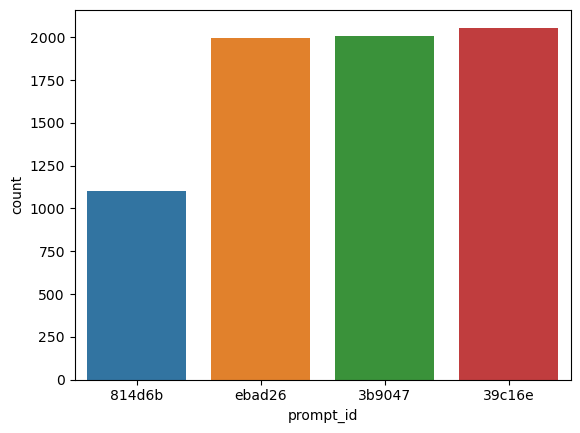

In [6]:
sns.countplot(x='prompt_id', data=df)
plt.show()

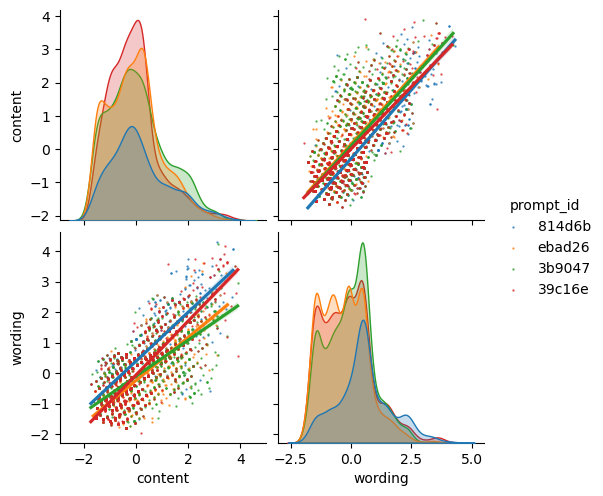

In [7]:
sns.pairplot(vars=['content', 'wording'], hue='prompt_id', data=df, diag_kind='kde', kind='reg', plot_kws={'scatter_kws': {'alpha': 0.8, 's': 0.4}})
plt.show()

## Feature Engineering

In [8]:
def spelling_errors(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

def punctuation_marks(text):
    return sum([1 for char in text if char in PUNCT_MARKS])

contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def handle_contractions(text):
    words = word_tokenize(text)
    words = [contractions[word] if word in contractions else word for word in words]
    return ' '.join(words)

def spell_correction(text):
    words = word_tokenize(text)
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    return ' '.join(corrected_words)

def end_sentence(text):
    if text[-1] not in ['!', '?', '.']:
        return text + '.'
    return text

def readability_features(text):
    s = Textatistic(text)
    return pd.Series([s.sent_count, s.word_count, s.sybl_count, s.char_count, s.polysyblword_count, s.dalechall_score,
                      s.flesch_score, s.fleschkincaid_score, s.gunningfog_score, s.smog_score])

def avg_word_length(text):
    words = text.split()
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    return(avg_word_length)

def stop_words(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in STOP_WORDS)

def lexical_types(text):
    words = word_tokenize(text)
    lexical_types = set(words)
    return len(lexical_types)

def syntatic_complexity_features(text):
    doc = nlp(text)
    total_tokens = len(doc)
    num_clauses = len([token for token in doc if token.dep_ == "ROOT"])
    num_sub_clauses = len([token for token in doc if token.dep_ == "acl" or token.dep_ == "advcl"])
    num_verb_phrases = len([chunk for chunk in doc.noun_chunks if chunk.root.pos_ == "VERB"])
    num_complex_noun_phrases = len([chunk for chunk in doc.noun_chunks if len(chunk) > 1])

    return pd.Series([num_clauses / total_tokens, num_sub_clauses / total_tokens, num_verb_phrases / total_tokens,
                      num_complex_noun_phrases / total_tokens])

def remove_stop_words(text):
    removed_stop_words = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return removed_stop_words

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

def feature_extraction_text(df, col, suffix, prompts=False):
    data = df.copy()
    
    # Fase 1
    if col == 'text':
        data['spelling_errors_' + suffix] = data[col].swifter.apply(spelling_errors)
        data['grammar_errors_' + suffix] = data[col].swifter.apply(grammar_errors)
        data['punctuation_marks_' + suffix] = data[col].apply(punctuation_marks)
    
    # Fase 2
    data[suffix + '_lemmatized'] = data[col].str.lower()
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(handle_contractions)
    
    if col == 'text':
        data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(spell_correction)
        
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(end_sentence)
    
    # Fase 3
    data['text_length_' + suffix] = data[suffix + '_lemmatized'].apply(len)
    
    data[['sent_count_' + suffix, 'word_count_' + suffix, 'sybl_count_' + suffix, 
          'char_count_' + suffix, 'polysyblword_count_' + suffix, 'dalechall_score_' + suffix, 
          'flesch_score_' + suffix, 'fleschkincaid_score_' + suffix, 'gunningfog_score_' + suffix,
          'smog_score_' + suffix]] = data[suffix + '_lemmatized'].swifter.apply(readability_features)
    
    data['stop_words_' + suffix] = data[suffix + '_lemmatized'].apply(stop_words)
    
    data['lexical_types_' + suffix] = data[suffix + '_lemmatized'].swifter.apply(lexical_types)
    
    data[['clauses_prop_' + suffix, 'sub_clauses_prop_' + suffix, 'verb_phrases_prop_' + suffix,
          'noun_phrases_prop_' + suffix]] = data[suffix + '_lemmatized'].swifter.apply(syntatic_complexity_features)
    
    data['chars_per_word_' + suffix] = data['char_count_' + suffix] / data['word_count_' + suffix]
    data['words_per_sentence_' + suffix] = data['word_count_' + suffix] / data['sent_count_' + suffix]
    data['sybl_per_sentence_' + suffix] = data['sybl_count_' + suffix] / data['sent_count_' + suffix] 
    
    # Fase 4
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(lemmatize_text)
    data[suffix + '_no_stopwords'] = data[suffix + '_lemmatized'].apply(remove_stop_words)
    
    return data

def fit_transform_tfidf(dataframe):
    tfidf_dict = {}

    for prompt_id in dataframe['prompt_id'].unique():
        prompt_text = dataframe[dataframe['prompt_id'] == prompt_id]['prompt_text'].iloc[[0]]

        vectorizer = TfidfVectorizer()
        
        tfidf_matrix = vectorizer.fit_transform(prompt_text)

        tfidf_dict[prompt_id] = {
            'vectorizer': vectorizer,
            'tfidf_vector': tfidf_matrix.toarray().flatten()
        }

    return tfidf_dict

def calculate_word_distance(row, tfidf_dict, text_column):
    tfidf_essay = tfidf_dict[row['prompt_id']]['vectorizer'].transform([row[text_column]])
    differences = tfidf_dict[row['prompt_id']]['tfidf_vector'] - tfidf_essay.toarray().flatten()
    return 1 / np.abs(differences).sum()

def feature_extraction_general(df):
    data = df.copy()
    
    ratio_columns = [
        'dalechall_score_', 'flesch_score_', 'fleschkincaid_score_', 'gunningfog_score_', 'smog_score_',
        'clauses_prop_', 'sub_clauses_prop_', 'verb_phrases_prop_', 'noun_phrases_prop_',
        'chars_per_word_', 'words_per_sentence_', 'sybl_per_sentence_'
    ]
    
    for col in ratio_columns:
        data[col + 'ratio'] = data[col + 'essay'] / data[col + 'prompt']
    
    tfidf_dict = fit_transform_tfidf(data)
    data['words_similarity'] = data.swifter.apply(
        calculate_word_distance,
        tfidf_dict=tfidf_dict,
        text_column='essay_no_stopwords',
        axis=1
    )
    
    return data

In [9]:
#df = feature_extraction_text(df, 'text', 'essay')
#df = feature_extraction_text(df, 'prompt_text', 'prompt')
#df = feature_extraction_text(df, 'prompt_question', 'question')
#df = feature_extraction_general(df)
#df.to_csv('train_features.csv', index=False)

## Preparacion del Modelo

In [10]:
def regression_report(y_true, y_pred, name):
    print(name)
    print('std =', np.std(y_true))
    print('rmse =', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('r2 =', r2_score(y_true, y_pred), '\n')

In [11]:
df = pd.read_csv('train_features.csv')
df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave   
1    Excerpt from The Jungle   
2  Egyptian Social Structure   
3  Egyptian Social Structure   
4             The Third Wave   

                                         prompt_text  spelling_errors_essay  \
0  Background \r\nThe Third Wave experiment took ...                      5   
1  With one member trimming beef in a cannery, an...                      2   
2  Egyptian society was structured like a pyramid...                     32   
3  Egyptian society was structured like a pyramid...                      5   
4  Background \r\nThe Third Wave experiment took ...                     29   

   grammar_errors_essay  ...  gunningfog_score_ratio smog_score_ratio  \
0                     3  ...                0.801371         0.909527   
1                     3  ...                0.616276         0.349426   
2                     2  ...                1.255015         1.022929   
3                     3  ...                1.111391         1.022929   
4                    15  ...                0.740977         0.846515   

   clauses_prop_ratio  sub_clauses_prop_ratio  verb_phrases_prop_ratio  \
0            1.576331                2.927473                      NaN   
1            1.610182                1.548252                      NaN   
2            0.634366                0.930403                      NaN   
3            0.995298                0.000000                      NaN   
4            1.539122                0.816677                      NaN   

   noun_phrases_prop_ratio  chars_per_word_ratio  words_per_sentence_ratio  \
0                 0.758974              0.965068                  0.673895   
1                 0.999226              0.880900                  0.657230   
2                 0.759513              0.943478                  1.593058   
3                 1.564039              1.072084                  0.493716   
4                 0.926323              0.990123                  0.672317   

   sybl_per_sentence_ratio  words_similarity  
0                 0.668706          0.106910  
1                 0.583910          0.096492  
2                 1.531459          0.085946  
3                 0.544846          0.098658  
4                 0.667582          0.103167  

[5 rows x 90 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   student_id                    7165 non-null   object 
 1   prompt_id                     7165 non-null   object 
 2   text                          7165 non-null   object 
 3   content                       7165 non-null   float64
 4   wording                       7165 non-null   float64
 5   prompt_question               7165 non-null   object 
 6   prompt_title                  7165 non-null   object 
 7   prompt_text                   7165 non-null   object 
 8   spelling_errors_essay         7165 non-null   int64  
 9   grammar_errors_essay          7165 non-null   int64  
 10  punctuation_marks_essay       7165 non-null   int64  
 11  essay_lemmatized              7165 non-null   object 
 12  text_length_essay             7165 non-null   int64  
 13  sen

In [13]:
X = df.drop([
    'student_id', 'prompt_id', 'prompt_title', 'content', 'wording'
], axis=1)

Y = df[['content', 'wording']]

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=24)

In [15]:
text_cols = [
    'text', 'essay_lemmatized', 'essay_no_stopwords',
    'prompt_text', 'prompt_lemmatized', 'prompt_no_stopwords',
    'prompt_question', 'question_lemmatized', 'question_no_stopwords'
]

X_train_features = X_train.drop(text_cols, axis=1)

X_val_features = X_val.drop(text_cols, axis=1)

In [16]:
xgb_model_1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_1 = MultiOutputRegressor(xgb_model_1).fit(X_train_features, Y_train)

multi_xgb_model_1.fit(X_train_features, Y_train)
predictions_xgb = multi_xgb_model_1.predict(X_val_features)

In [17]:
regression_report(Y_train['content'], multi_xgb_model_1.predict(X_train_features)[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_1.predict(X_train_features)[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.39389386301925006
r2 = 0.8589487416635762 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4607549811780617
r2 = 0.796756937542155 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5229289971289345
r2 = 0.7485786542153607 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6174299774518763
r2 = 0.6244602508090671 



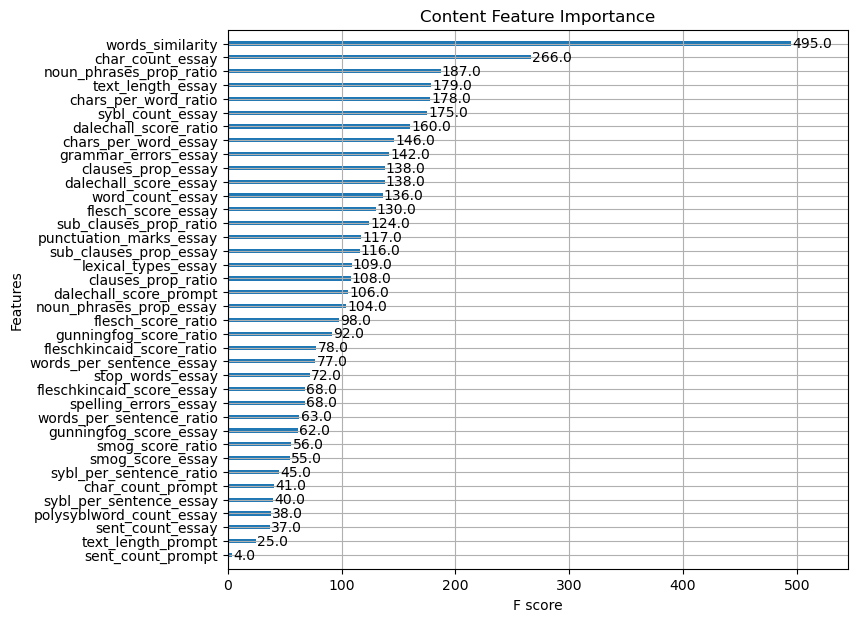

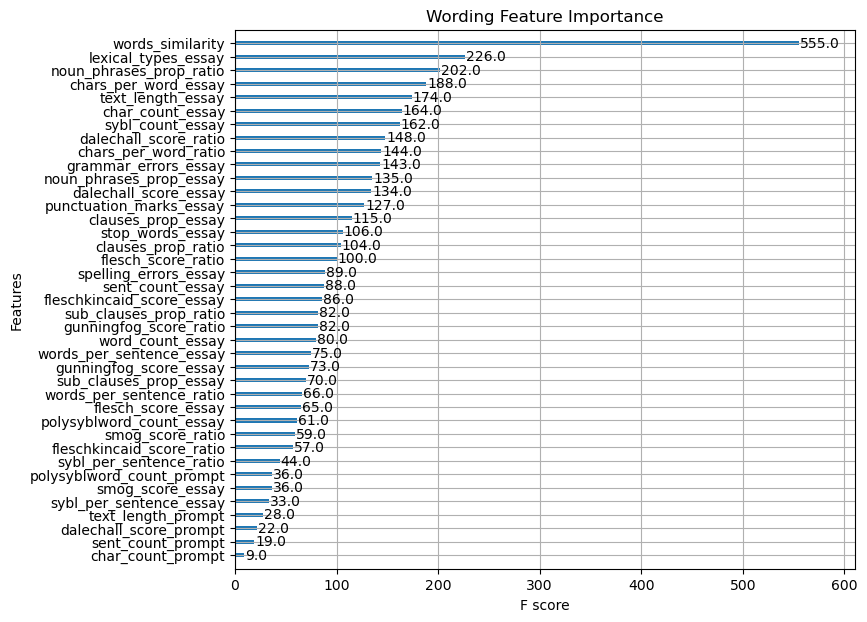

In [18]:
fig, ax = plt.subplots(figsize=(8, 7))
xgb.plot_importance(multi_xgb_model_1.estimators_[0], height=0.3, title='Content Feature Importance', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8, 7))
xgb.plot_importance(multi_xgb_model_1.estimators_[1], height=0.3, title='Wording Feature Importance', ax=ax)
plt.show()

In [19]:
content_importances = multi_xgb_model_1.estimators_[0].get_booster().get_score(importance_type='weight')
wording_importances = multi_xgb_model_1.estimators_[1].get_booster().get_score(importance_type='weight')

features_used = set(content_importances.keys()).union(set(wording_importances.keys()))
features_to_keep = features_used - {'sent_count_pompt', 'char_count_prompt', 'text_length_prompt', 'polysyblword_count_prompt'}

print("Total selected features:", len(features_to_keep))

xgb_model_2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_2 = MultiOutputRegressor(xgb_model_2).fit(X_train_features, Y_train)

multi_xgb_model_2.fit(X_train_features[features_to_keep], Y_train)
predictions_xgb = multi_xgb_model_2.predict(X_val_features[features_to_keep])

Total selected features: 36


In [20]:
regression_report(Y_train['content'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.39376813338141836
r2 = 0.859038773496625 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4611865696984076
r2 = 0.796376004254185 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5234339458917947
r2 = 0.748092866687543 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6178233334240678
r2 = 0.6239815961795188 



## Incidencia de Variables

In [21]:
def plot_numeric_features(df, features, target):
    df_plot = df.copy()

    for col in features:
        df_plot[col] = pd.qcut(df[col], q=4, labels=False)

        sns.boxplot(
            x=target,
            y=col,
            orient='h',
            data=df_plot,
            showfliers=False
        )

        plt.title(col)
        plt.show()

13


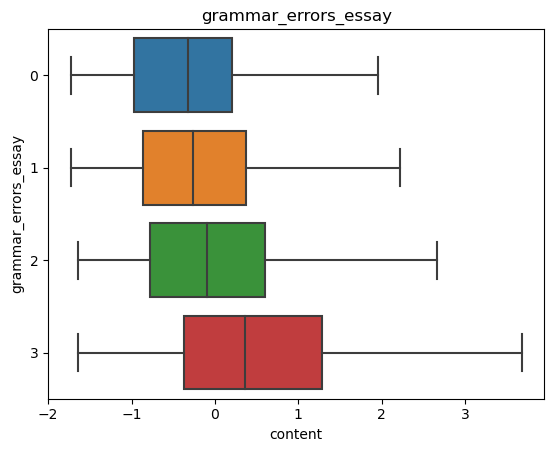

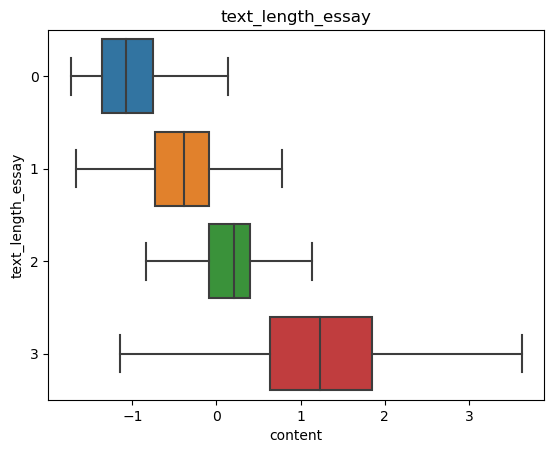

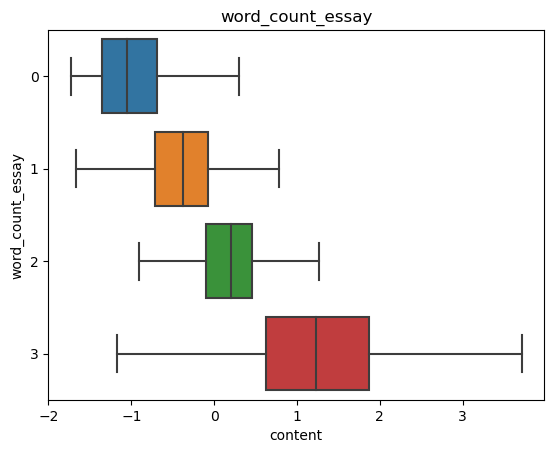

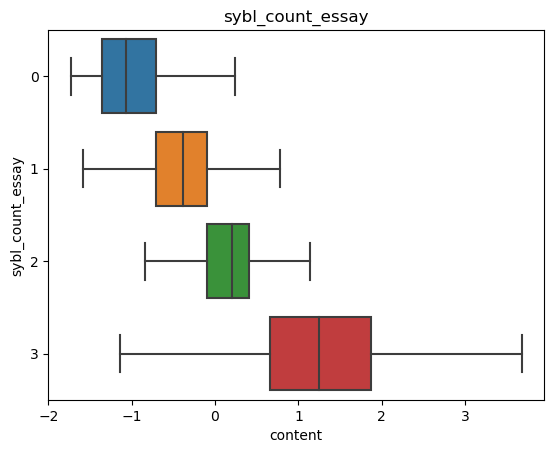

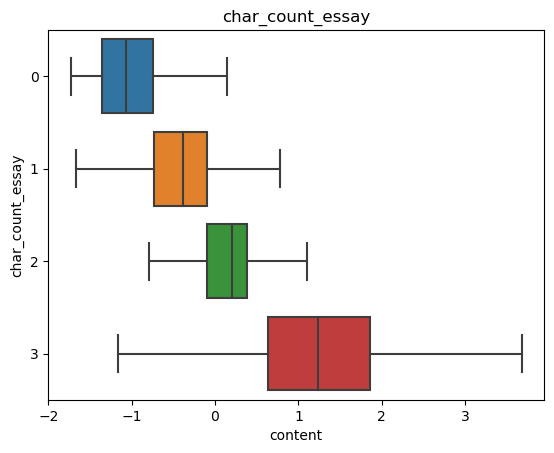

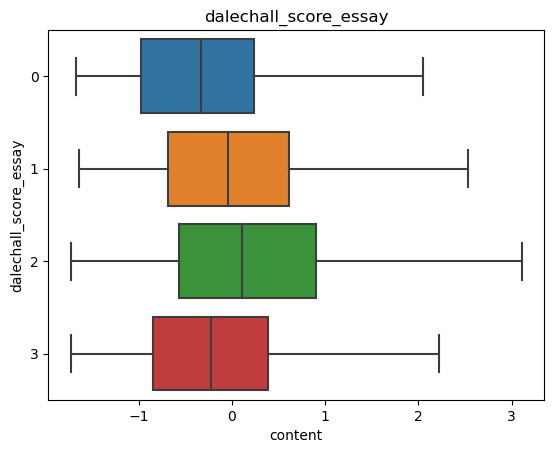

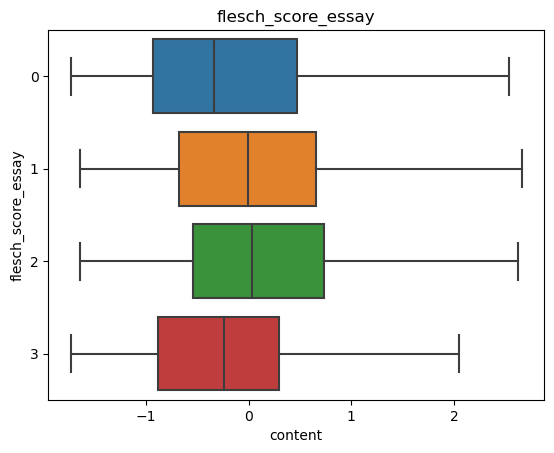

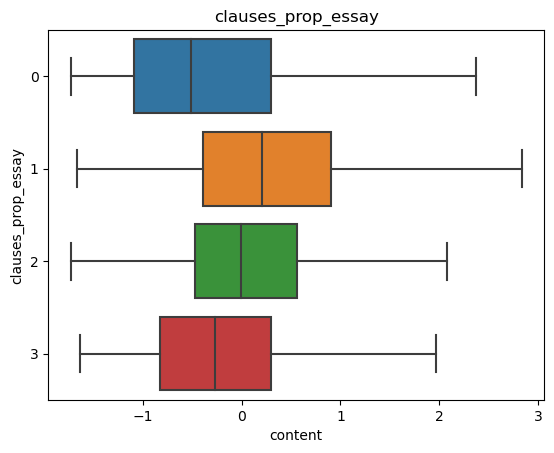

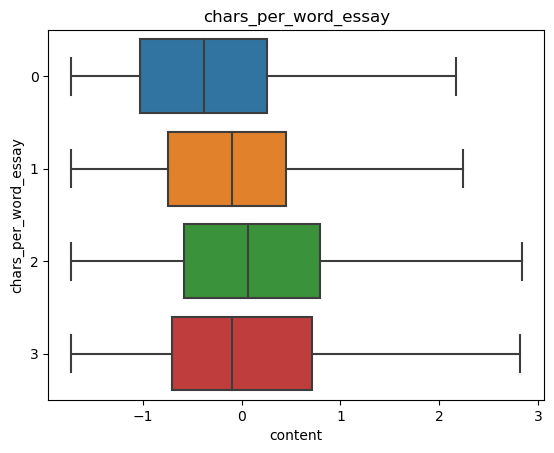

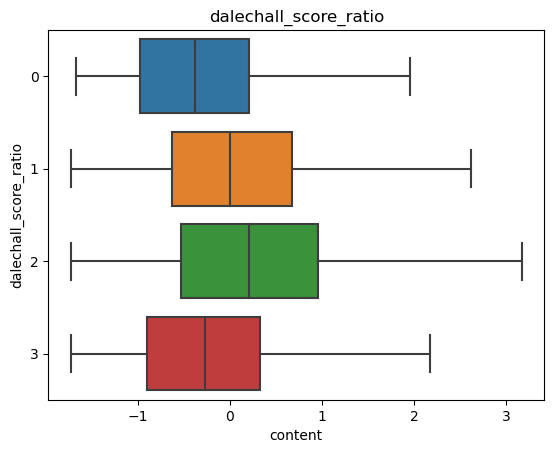

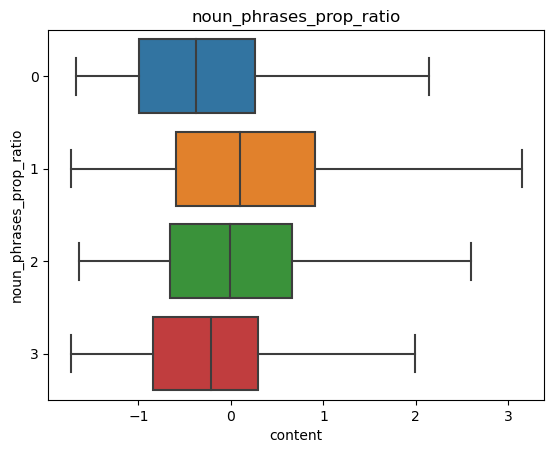

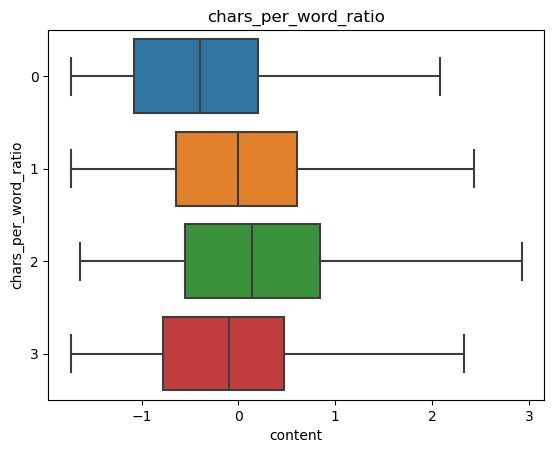

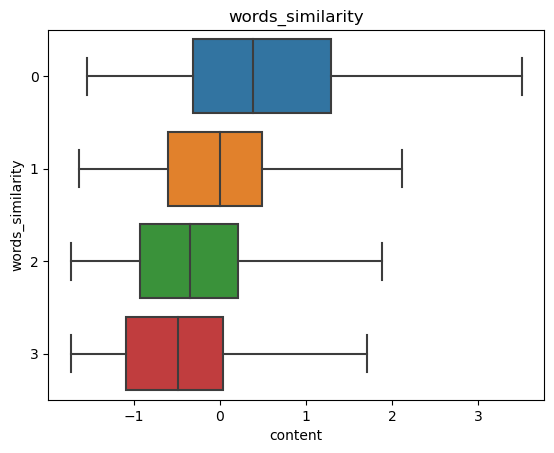

In [22]:
features_to_plot = [feature for feature, importance in content_importances.items() if importance >= 130]
print(len(features_to_plot))

plot_numeric_features(df, features_to_plot, 'content')

13


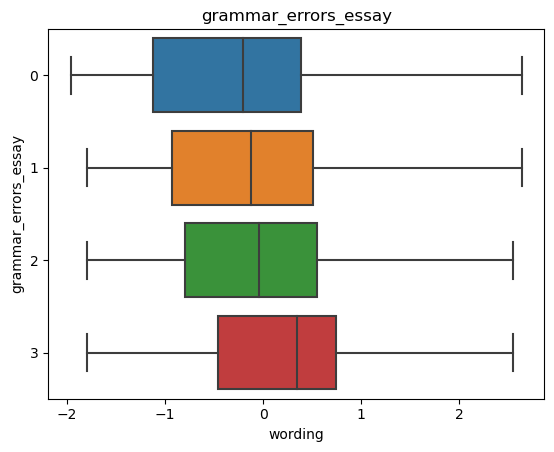

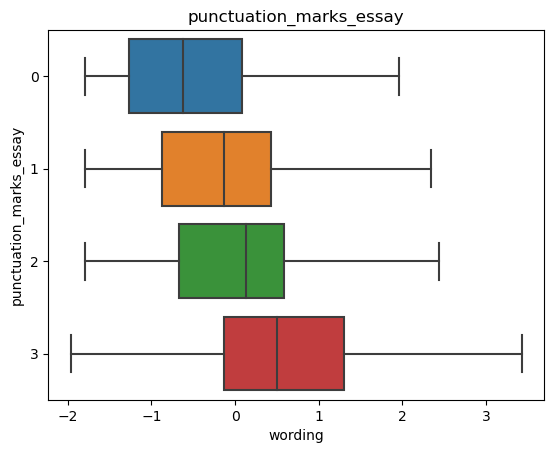

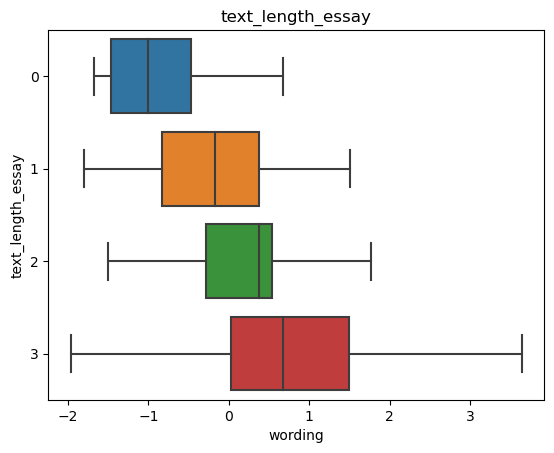

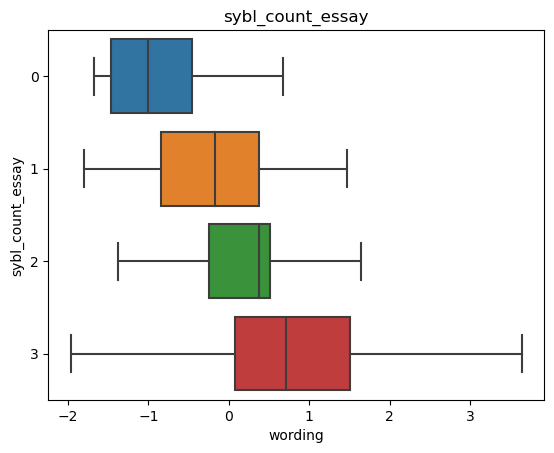

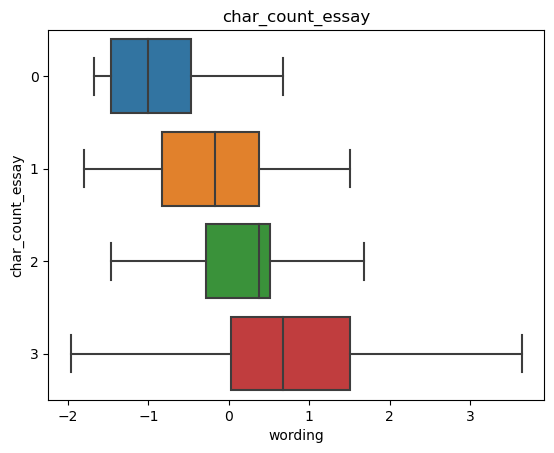

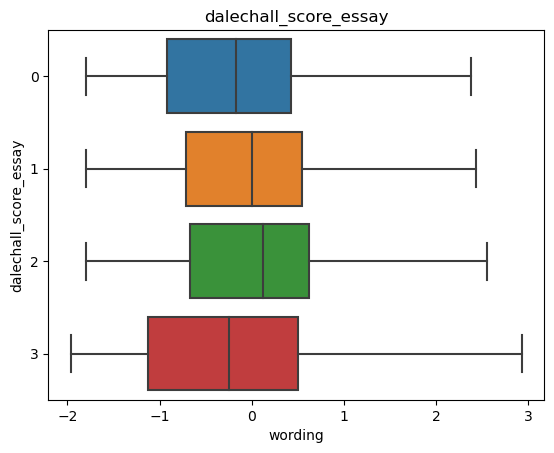

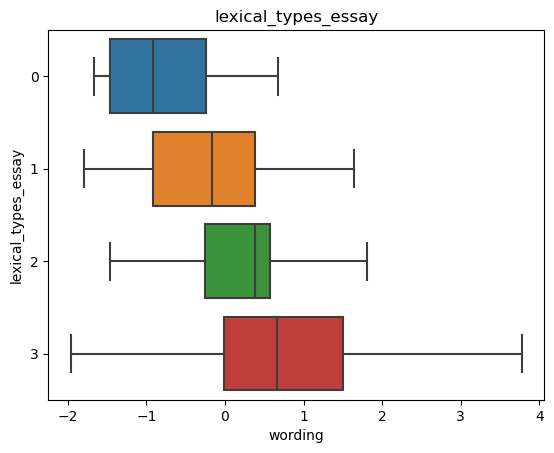

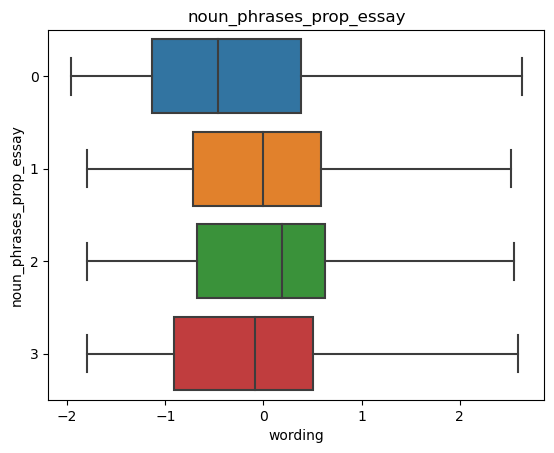

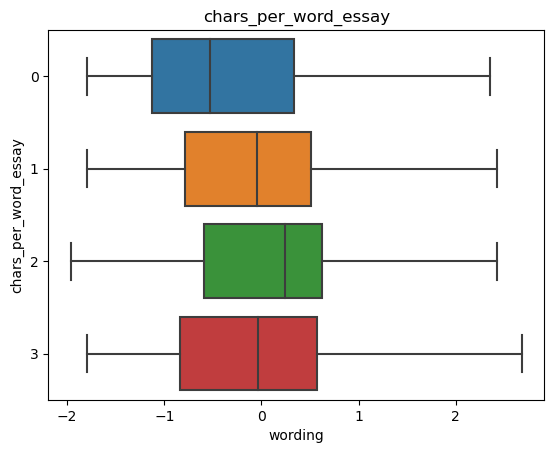

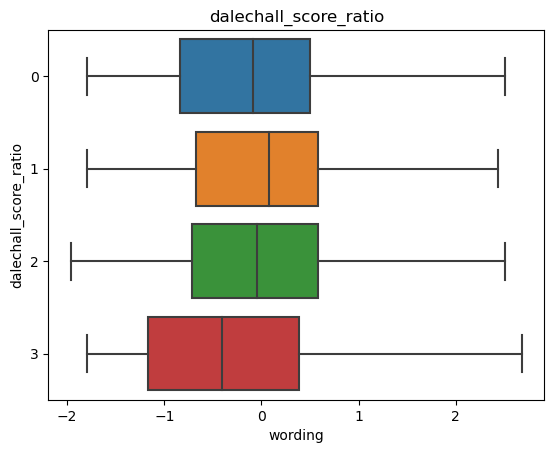

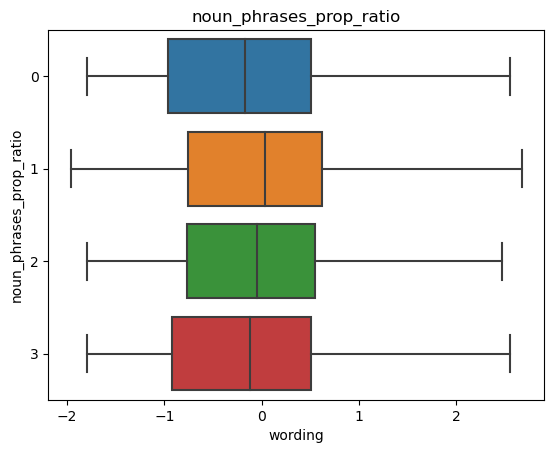

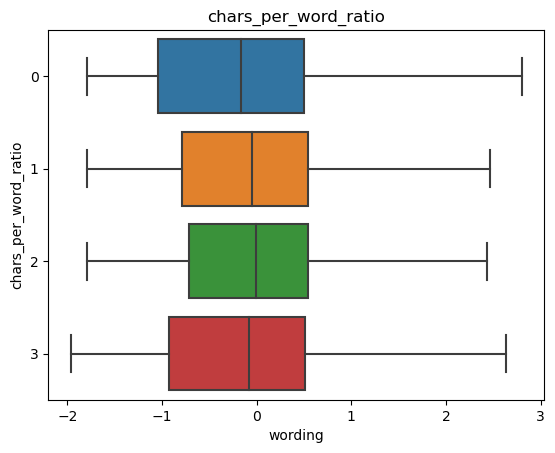

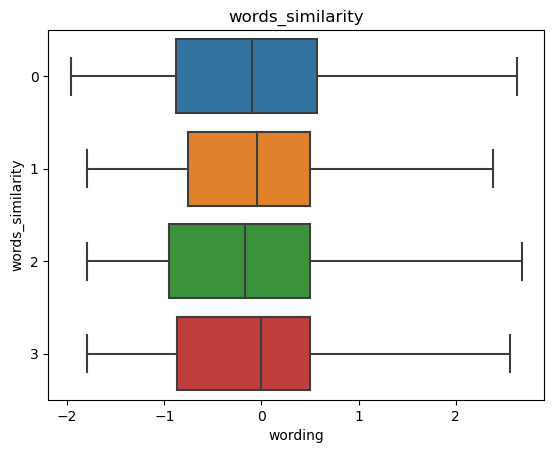

In [23]:
features_to_plot = [feature for feature, importance in wording_importances.items() if importance >= 120]
print(len(features_to_plot))

plot_numeric_features(df, features_to_plot, 'wording')

## Deep Learning Model

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, concatenate, Dense
from tensorflow.keras.models import Model
from keras import backend as K

def r2_score_keras(y_true, y_pred):
    r2 = r2_score(K.eval(y_true), K.eval(y_pred))
    return K.constant(r2, dtype=tf.float32)

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['prompt_no_stopwords'] + X_train['question_no_stopwords'] + X_train['essay_no_stopwords'])

max_sequence_length = 100
vocab_size = len(tokenizer.word_index) + 1  

sequences_prompt_texts = tokenizer.texts_to_sequences(X_train['prompt_no_stopwords'])
sequences_prompt_questions = tokenizer.texts_to_sequences(X_train['question_no_stopwords'])
sequences_texts = tokenizer.texts_to_sequences(X_train['essay_no_stopwords'])

prompt_text_train = pad_sequences(sequences_prompt_texts, maxlen=max_sequence_length)
question_text_train = pad_sequences(sequences_prompt_questions, maxlen=max_sequence_length)
essay_text_train = pad_sequences(sequences_texts, maxlen=max_sequence_length)

sequences_prompt_texts = tokenizer.texts_to_sequences(X_val['prompt_no_stopwords'])
sequences_prompt_questions = tokenizer.texts_to_sequences(X_val['question_no_stopwords'])
sequences_texts = tokenizer.texts_to_sequences(X_val['essay_no_stopwords'])

prompt_text_val = pad_sequences(sequences_prompt_texts, maxlen=max_sequence_length)
question_text_val = pad_sequences(sequences_prompt_questions, maxlen=max_sequence_length)
essay_text_val = pad_sequences(sequences_texts, maxlen=max_sequence_length)

In [26]:
# Define input layers
input_prompt_text = Input(shape=(max_sequence_length,))
input_prompt_question = Input(shape=(max_sequence_length,))
input_text = Input(shape=(max_sequence_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100)  # Adjust the output_dim as needed

# Apply embedding to inputs
embedded_prompt_text = embedding_layer(input_prompt_text)
embedded_prompt_question = embedding_layer(input_prompt_question)
embedded_text = embedding_layer(input_text)

# LSTM layers to process embeddings
lstm_layer = LSTM(units=64)

lstm_output_prompt_text = lstm_layer(embedded_prompt_text)
lstm_output_prompt_question = lstm_layer(embedded_prompt_question)
lstm_output_text = lstm_layer(embedded_text)

# Concatenate the LSTM outputs
merged_output = concatenate([lstm_output_prompt_text, lstm_output_prompt_question, lstm_output_text])

# Dense layer for the final prediction
dense_layer = Dense(units=2, activation='linear')
output = dense_layer(merged_output)

# Create the Siamese model
siamese_model = Model(inputs=[input_prompt_text, input_prompt_question, input_text], outputs=output)

# Compile the model (choose appropriate optimizer and loss based on your task)
siamese_model.compile(optimizer='adam', loss='mse')

# Print model summary
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             740100    ['input_1[0][0]',             
                                                                     'input_2[0][0]',         

In [27]:
siamese_model.fit(
    [prompt_text_train, question_text_train, essay_text_train], Y_train,
    epochs=5,
    batch_size=128,
    validation_data=([prompt_text_val, question_text_val, essay_text_val], Y_val)
)

predictions_nn = siamese_model.predict([prompt_text_val, question_text_val, essay_text_val])

Epoch 1/5
45/45 [==============================] - 30s 526ms/step - loss: 0.6959 - val_loss: 0.3961
Epoch 2/5
45/45 [==============================] - 40s 890ms/step - loss: 0.3799 - val_loss: 0.3355
Epoch 3/5
45/45 [==============================] - 37s 820ms/step - loss: 0.3046 - val_loss: 0.3165
Epoch 4/5
45/45 [==============================] - 37s 823ms/step - loss: 0.2620 - val_loss: 0.3121
Epoch 5/5
45/45 [==============================] - 3s 31ms/step


In [28]:
regression_report(Y_train['content'], siamese_model.predict([prompt_text_train, question_text_train, essay_text_train])[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_nn[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], siamese_model.predict([prompt_text_train, question_text_train, essay_text_train])[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_nn[:, 1], 'WORDING TEST')

180/180 [==============================] - 6s 35ms/step
CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.3683219209435997
r2 = 0.8766685975692032 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.47369632379582544
r2 = 0.7851795209150421 

180/180 [==============================] - 7s 37ms/step
WORDING TRAIN
std = 1.04289755999341
rmse = 0.48577986357612024
r2 = 0.7830319856501851 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6308933205414414
r2 = 0.607904057901266 



## Análisis de Resultados

In [88]:
def plot_predictions(df, target_col, pred_col):
    sns.jointplot(
        x=target_col, 
        y=pred_col,
        data=df_val,
        kind='reg',
        joint_kws=dict(line_kws=dict(color='r', linewidth=3), scatter_kws=dict(alpha=0.5, s=10)),
    )
    plt.show()

def plot_predictions_features(df, features, target_col, pred_col, bins=5):
    df_plot = df.copy()
    
    r2_general = mean_squared_error(df_plot[target_col], df_plot[pred_col])
    
    for col in features:
        df_plot[col] = pd.qcut(df[col], q=bins, labels=False)
        
        sns.jointplot(
            x=target_col, 
            y=pred_col,
            data=df_plot,
            kind='scatter',
            hue=col
            #joint_kws=dict(line_kws=dict(color='r', linewidth=3), scatter_kws=dict(alpha=0.5, s=10)),
        )
        
        plt.show()
        
        r2_bins = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col]
        ) for i in range(bins)]
        
        plt.axhline(y=r2_general, color='r', linestyle='--')
        plt.plot(r2_bins)
        plt.title(col + ' R2 scores')
        plt.show()
        
def plot_predictions_comparisson(df, features, target_col, pred_col_1, pred_col_2, bins=5):
    df_plot = df.copy()
    
    r2_general_1 = mean_squared_error(df_plot[target_col], df_plot[pred_col_1])
    r2_general_2 = mean_squared_error(df_plot[target_col], df_plot[pred_col_2])
    
    for col in features:
        df_plot[col] = pd.qcut(df[col], q=bins, labels=False)
        
        r2_bins_1 = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col_1]
        ) for i in range(bins)]
        
        r2_bins_2 = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col_2]
        ) for i in range(bins)]
        
        plt.axhline(y=r2_general_1, color='#1f77b4', linestyle='--')
        plt.axhline(y=r2_general_2, color='#ff7f0e', linestyle='--')
        plt.plot(r2_bins_1, label=pred_col_1, color='#1f77b4')
        plt.plot(r2_bins_2, label=pred_col_2, color='#ff7f0e')
        plt.legend()
        plt.title(col + ' MSE scores')
        plt.show()

In [89]:
df_val = X_val.join(Y_val)
df_val[['content_pred', 'wording_pred']] = predictions_nn
df_val.head()

text  \
1759  The factory  mixed spoiled meat with other mea...   
2313  they ould chop it up cover the smell put gelit...   
2282  1 element of and ideal tragedy is the down fal...   
2740  The factorys would do anything in their power ...   
3978  Public pressure during the aftermath of the bo...   

                                        prompt_question  \
1759  Summarize the various ways the factory would u...   
2313  Summarize the various ways the factory would u...   
2282  Summarize at least 3 elements of an ideal trag...   
2740  Summarize the various ways the factory would u...   
3978  Summarize the various ways the factory would u...   

                                            prompt_text  \
1759  With one member trimming beef in a cannery, an...   
2313  With one member trimming beef in a cannery, an...   
2282  Chapter 13 \r\nAs the sequel to what has alrea...   
2740  With one member trimming beef in a cannery, an...   
3978  With one member trimming beef in a cannery, an...   

      spelling_errors_essay  grammar_errors_essay  punctuation_marks_essay  \
1759                      5                     2                        8   
2313                      3                     7                        1   
2282                      3                     7                        1   
2740                      8                     2                        7   
3978                      3                     0                        3   

                                       essay_lemmatized  text_length_essay  \
1759  the factory mixed spoiled meat with other meat...                347   
2313  they ould chop it up cover the smell put genit...                226   
2282  element of and ideal tragedy is the down fall ...                331   
2740  the factory would do anything in their power t...                286   
3978  public pressure during the aftermath of the bo...                180   

      sent_count_essay  word_count_essay  ...  verb_phrases_prop_ratio  \
1759               3.0              70.0  ...                      NaN   
2313               1.0              49.0  ...                      NaN   
2282               1.0              63.0  ...                      NaN   
2740               2.0              58.0  ...                      NaN   
3978               1.0              29.0  ...                      NaN   

      noun_phrases_prop_ratio  chars_per_word_ratio  words_per_sentence_ratio  \
1759                 0.619821              0.922239                  0.589821   
2313                 0.628085              0.857334                  1.238625   
2282                 1.451619              0.927127                  2.625000   
2740                 0.747720              0.924812                  0.733064   
3978                 1.519561              1.227626                  0.733064   

      sybl_per_sentence_ratio  words_similarity   content   wording  \
1759                 0.555075          0.095279 -0.301962  0.077857   
2313                 1.189446          0.096369 -0.511077 -1.589115   
2282                 2.522639          0.098061 -0.826271 -1.428527   
2740                 0.670415          0.091173 -1.033882 -1.086703   
3978                 1.016436          0.108956 -1.547163 -1.461245   

      content_pred  wording_pred  
1759     -0.349866     -0.338587  
2313     -0.804024     -0.657209  
2282      0.097108      0.518763  
2740     -0.684994     -1.064346  
3978     -1.393879     -1.053106  

[5 rows x 89 columns]

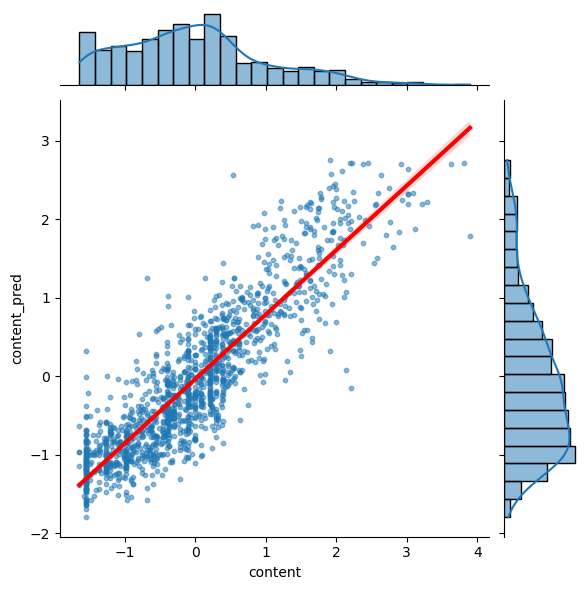

In [90]:
plot_predictions(df_val, 'content', 'content_pred')

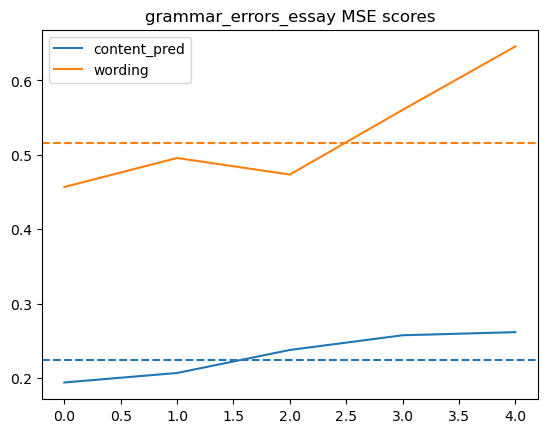

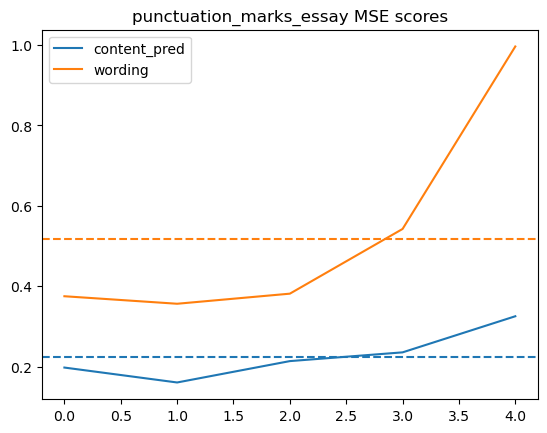

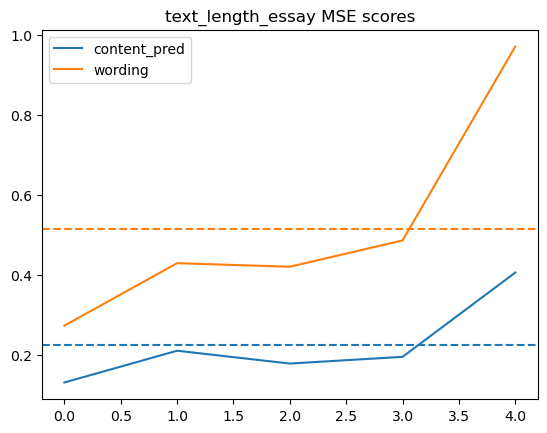

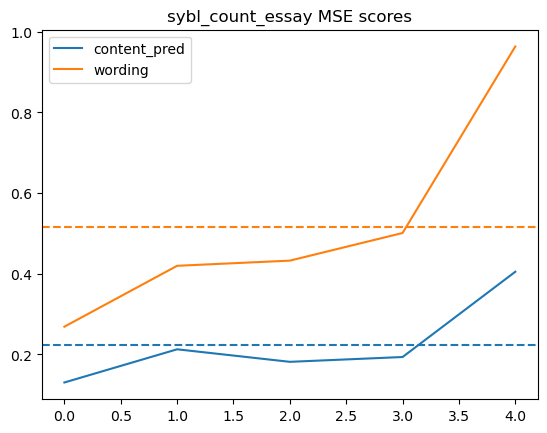

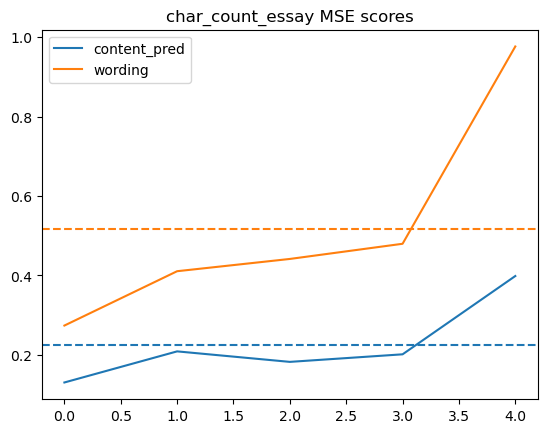

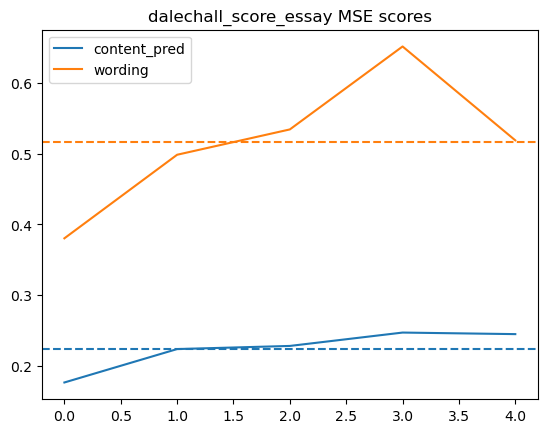

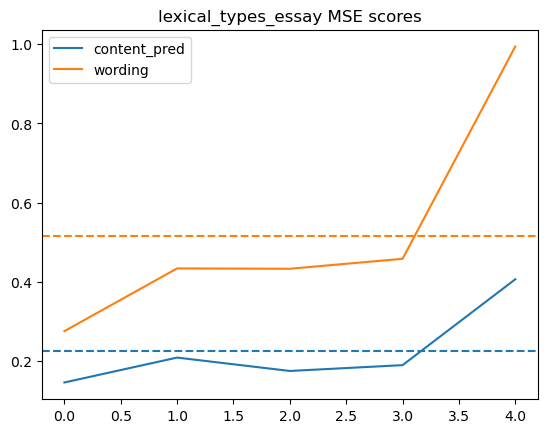

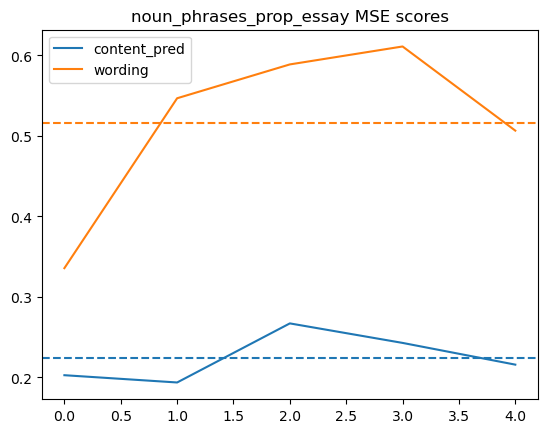

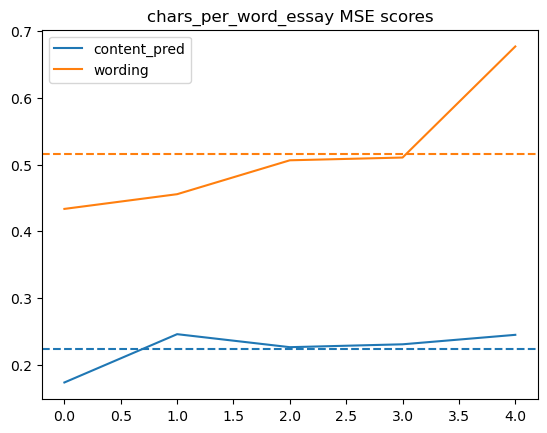

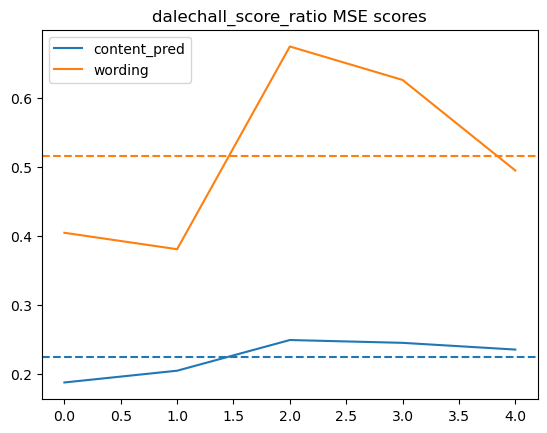

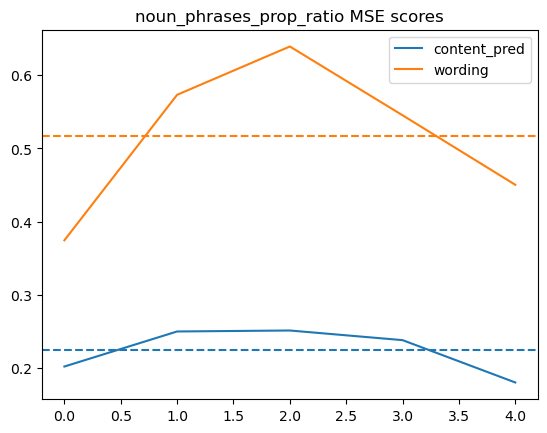

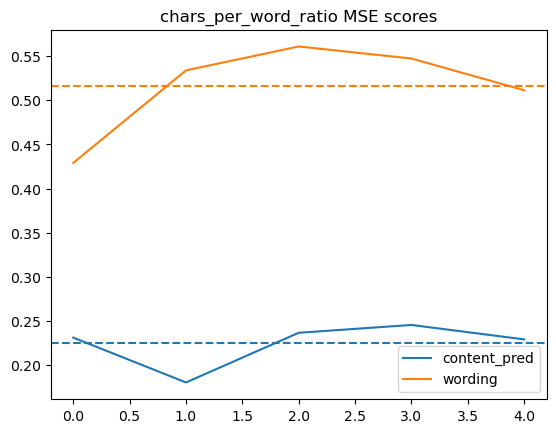

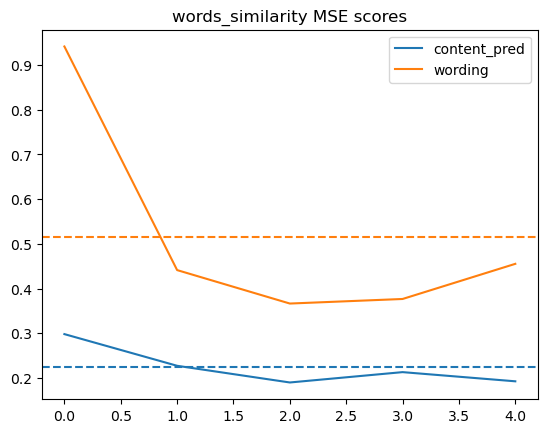

In [84]:
plot_predictions_comparisson(df_val, features_to_plot, 'content', 'content_pred', 'wording')

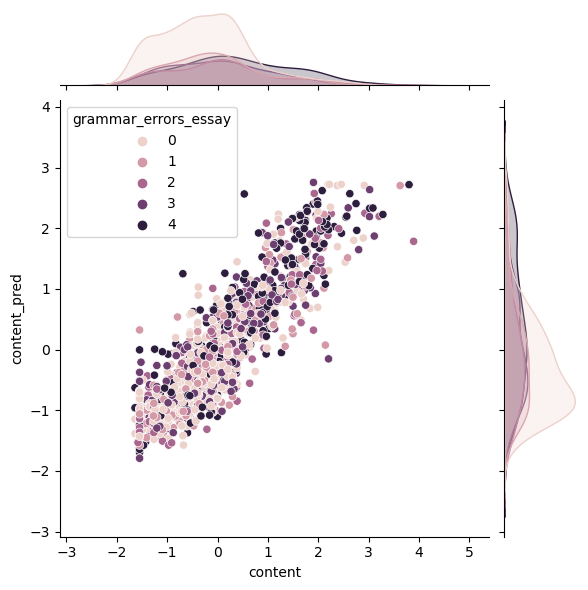

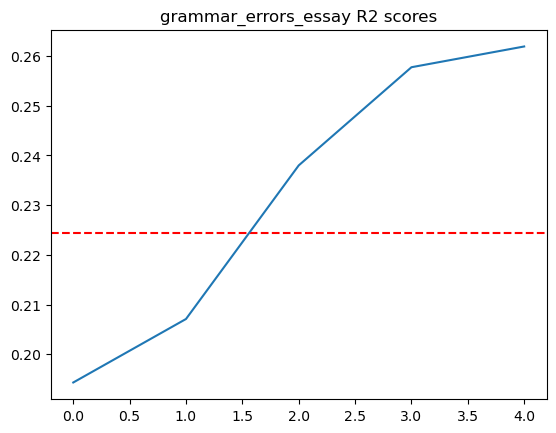

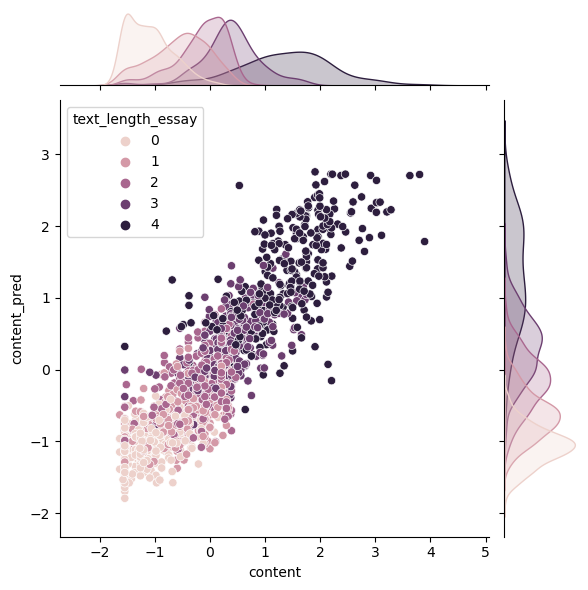

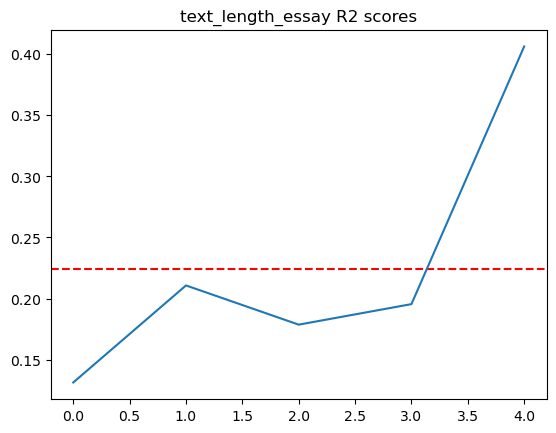

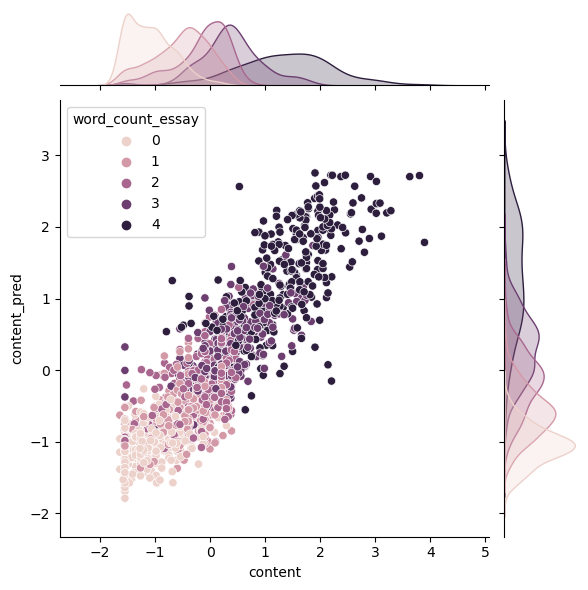

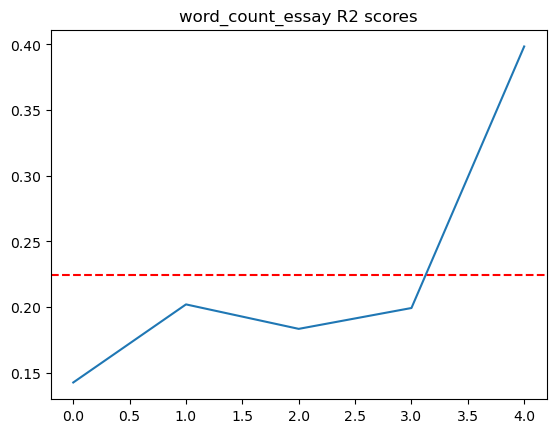

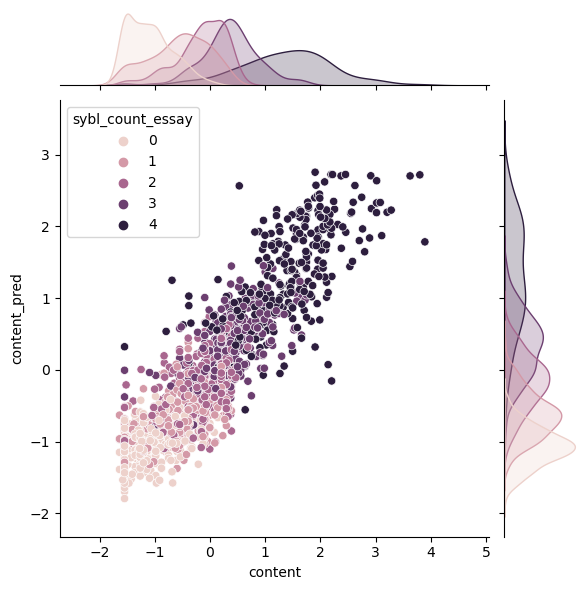

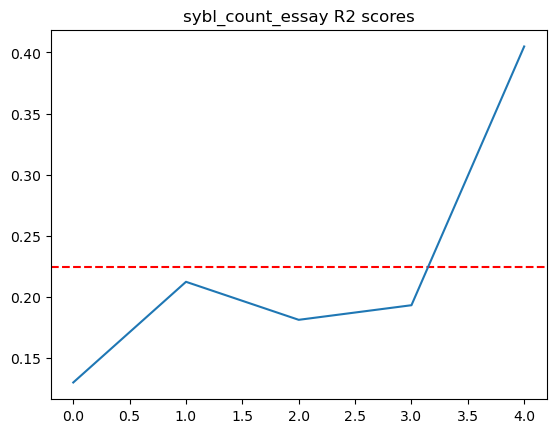

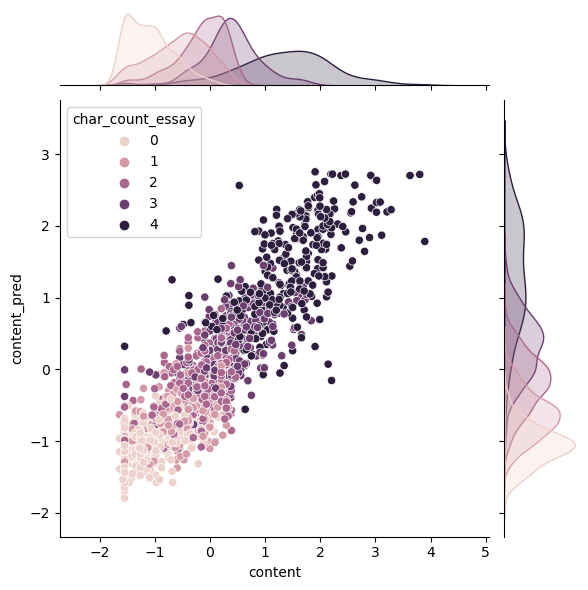

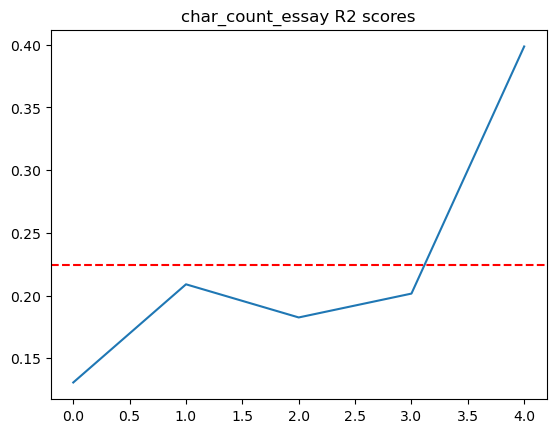

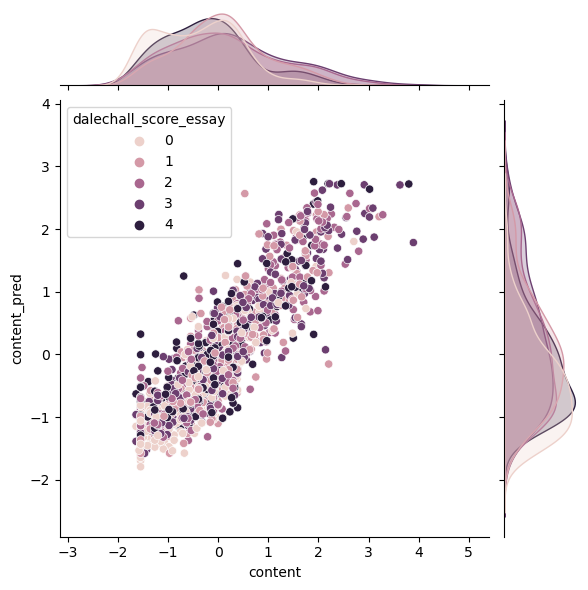

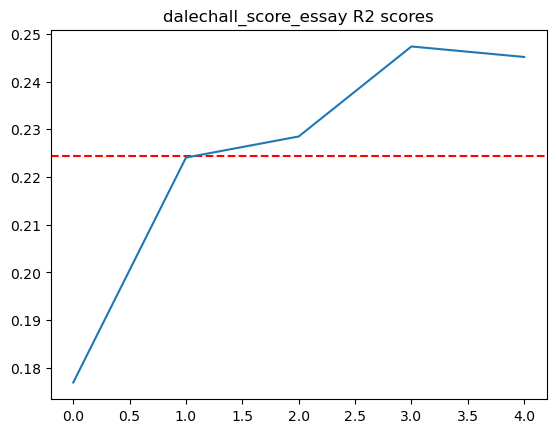

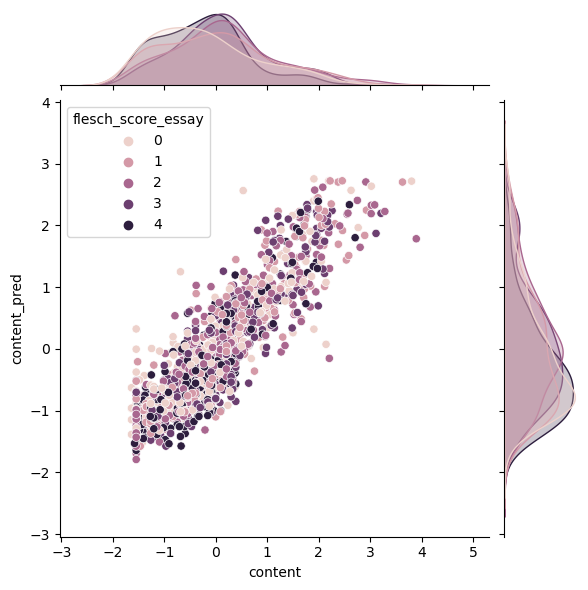

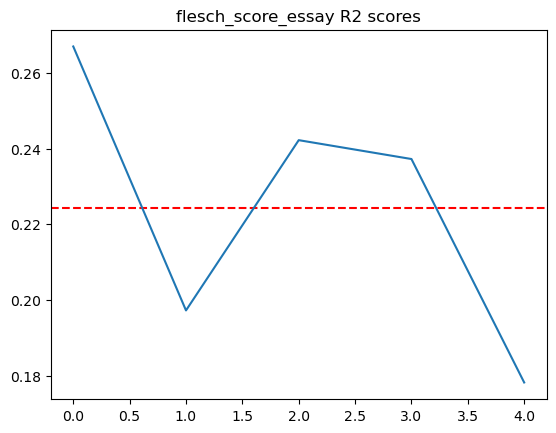

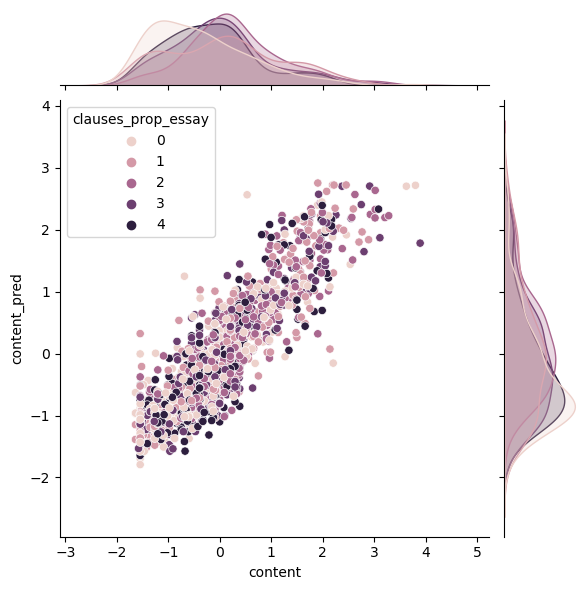

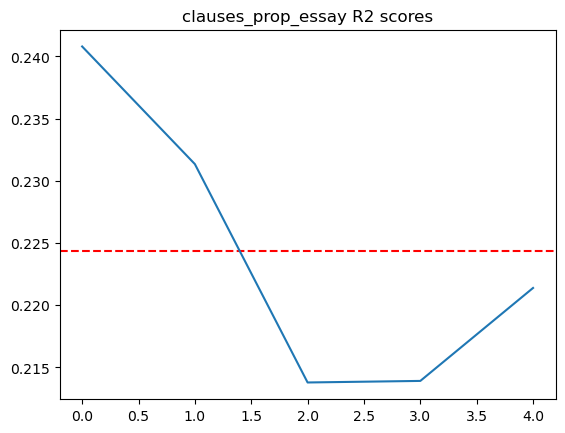

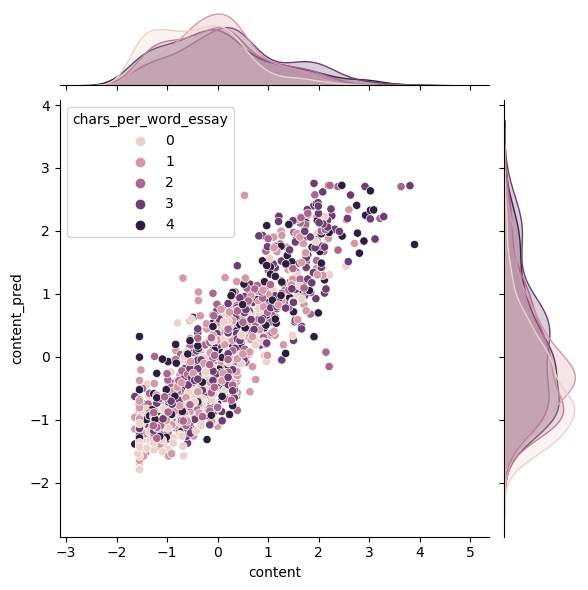

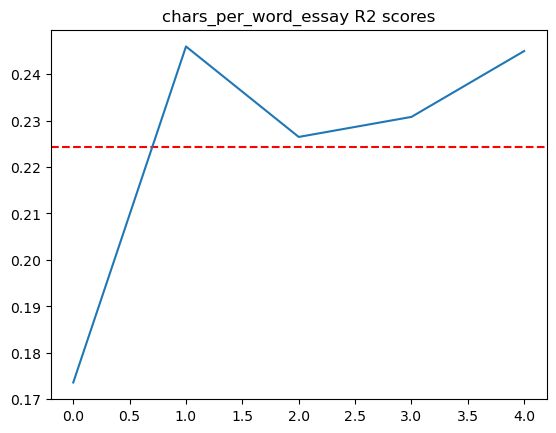

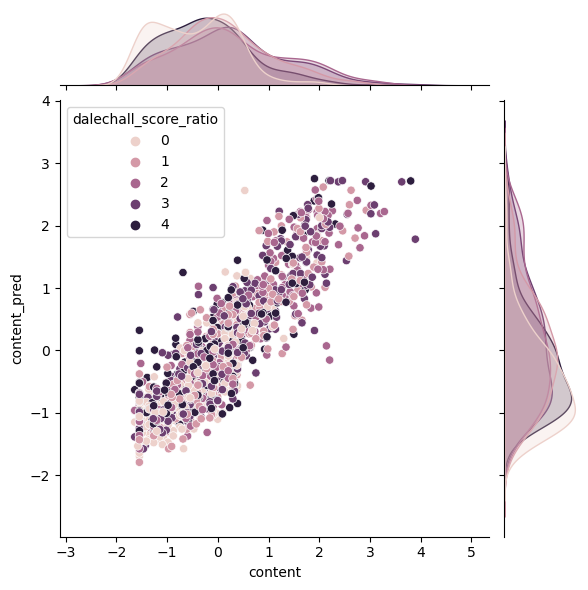

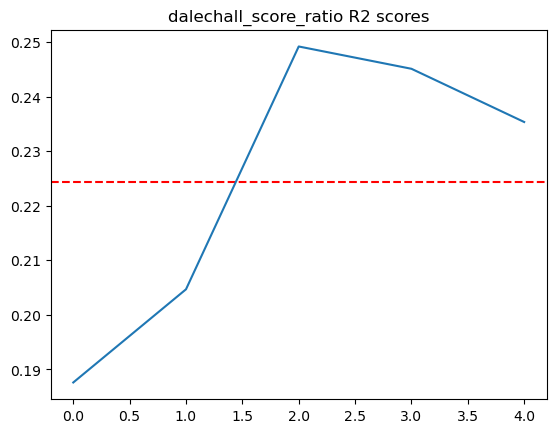

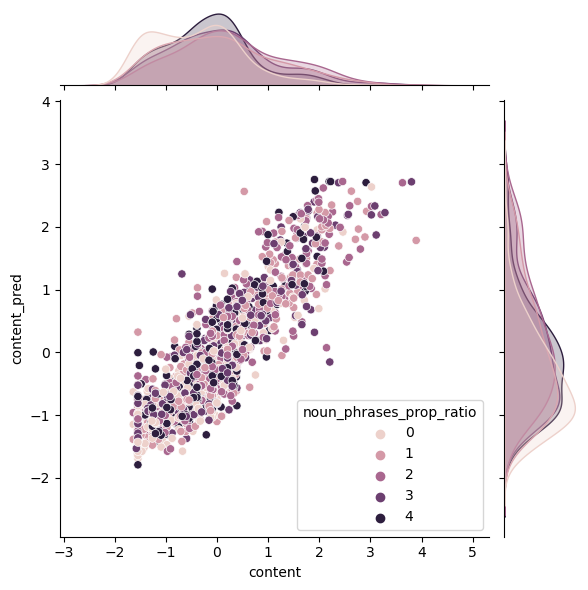

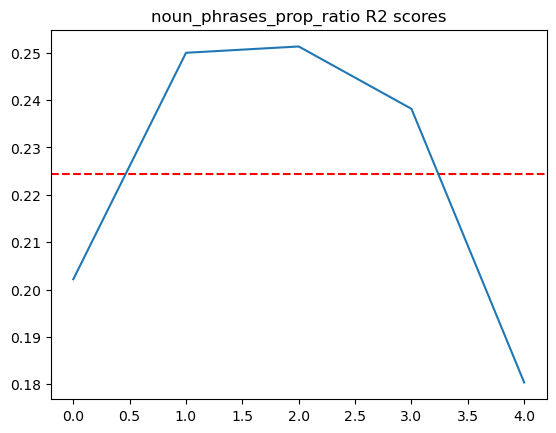

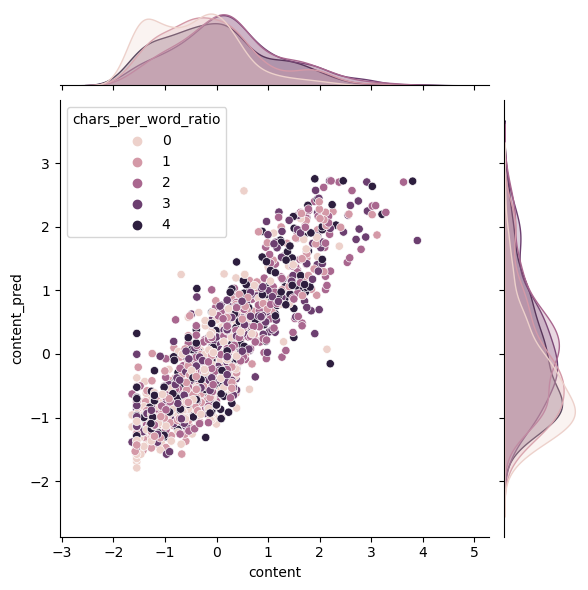

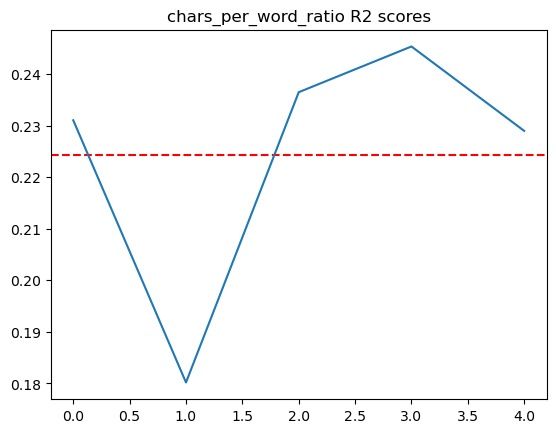

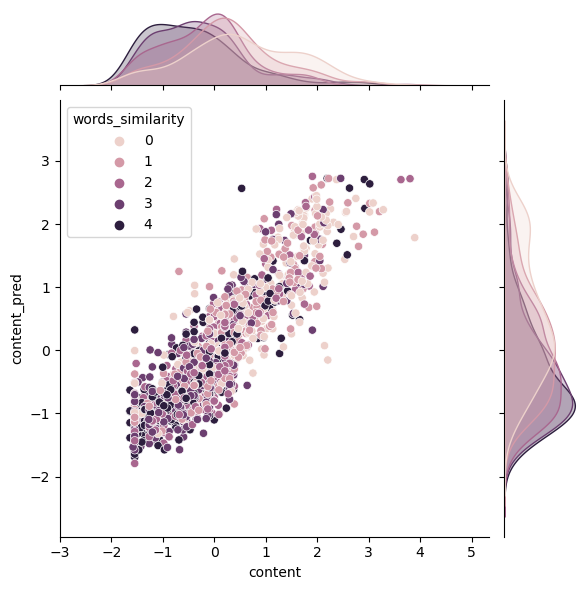

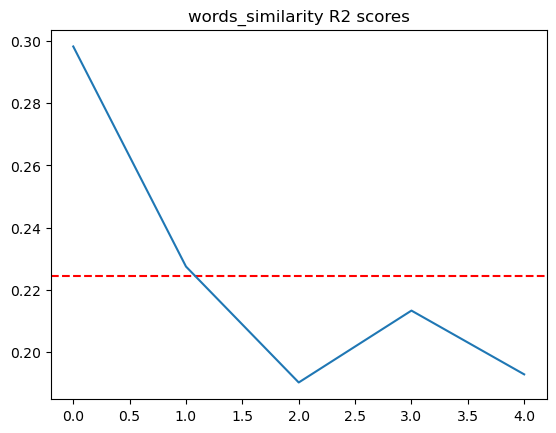

In [71]:
features_to_plot = [feature for feature, importance in content_importances.items() if importance >= 130]
plot_predictions_features(df_val, features_to_plot, 'content', 'content_pred')

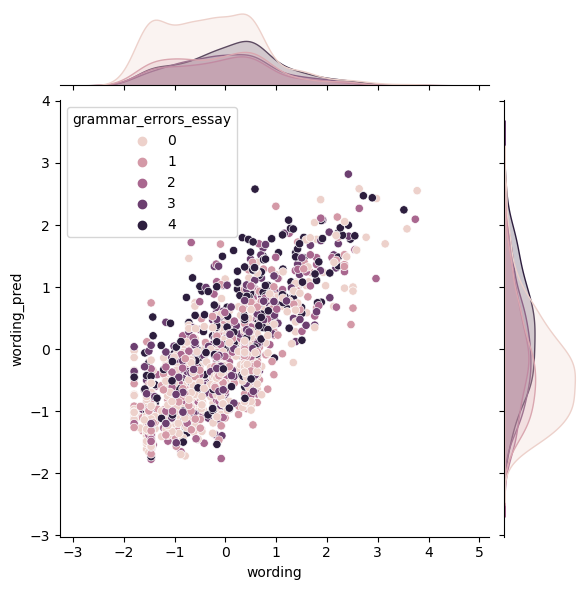

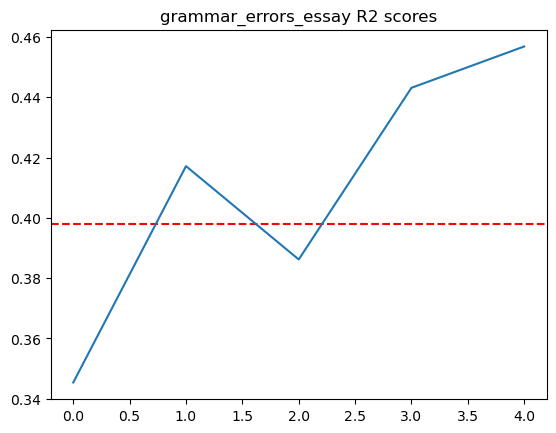

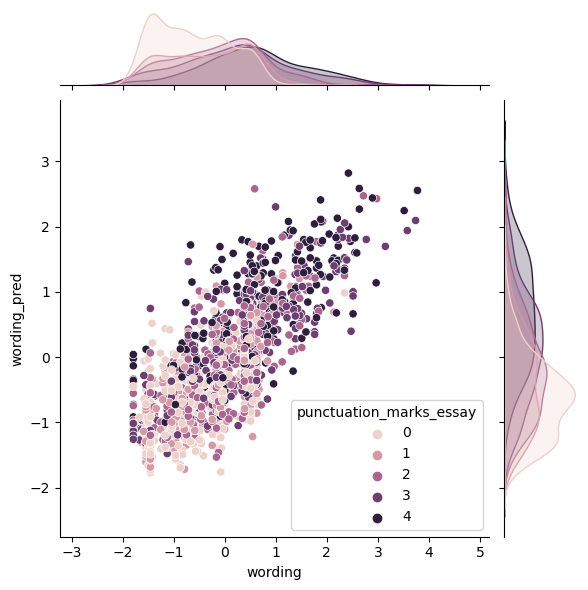

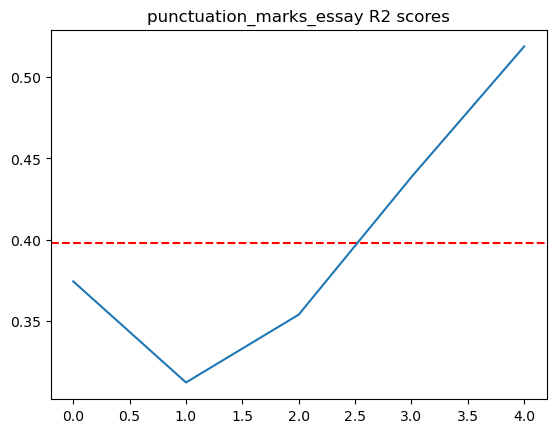

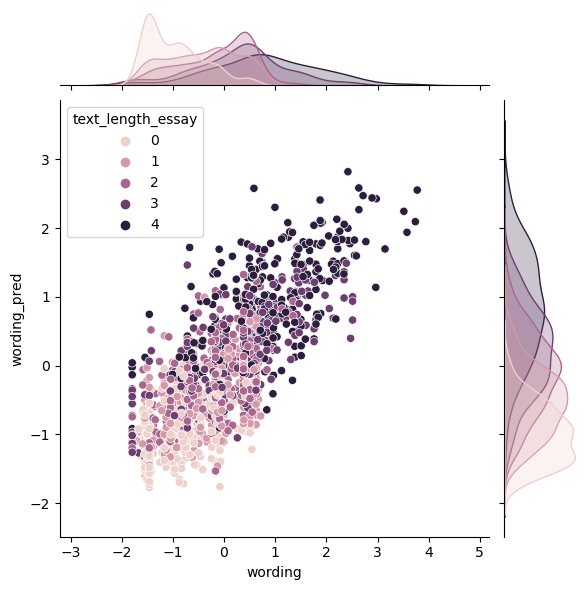

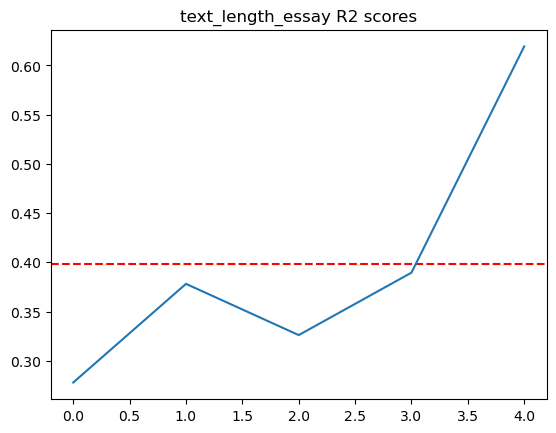

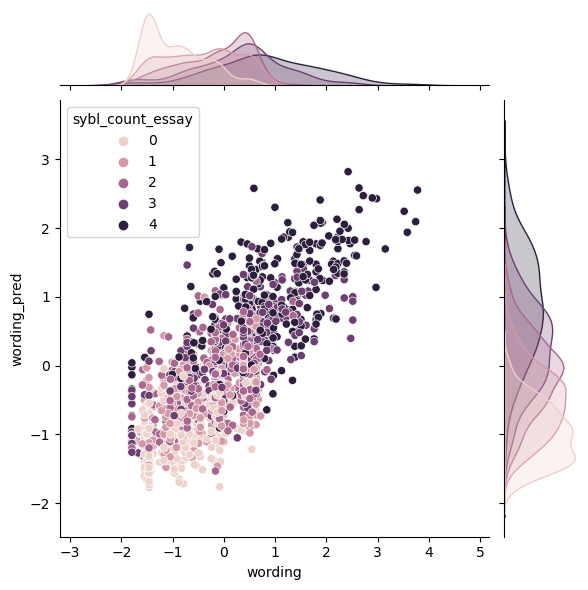

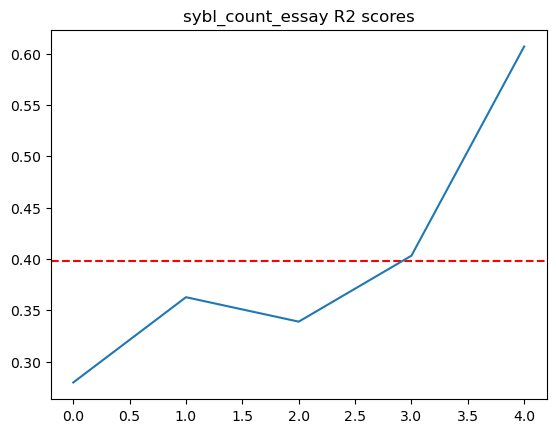

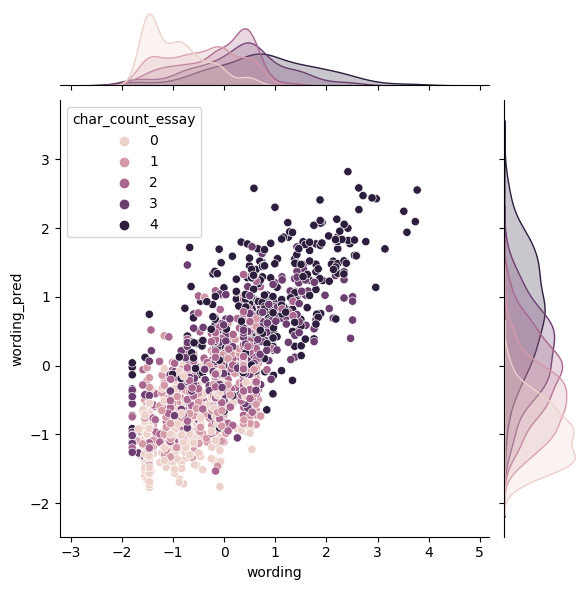

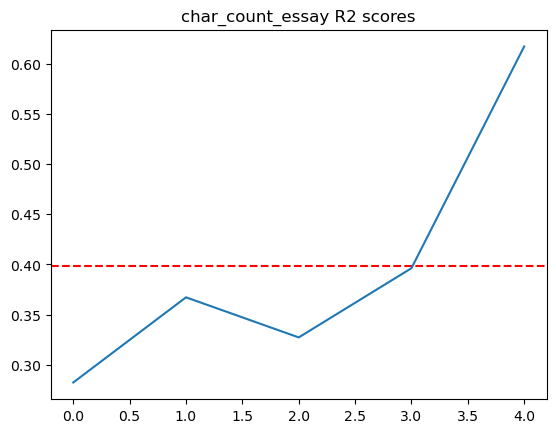

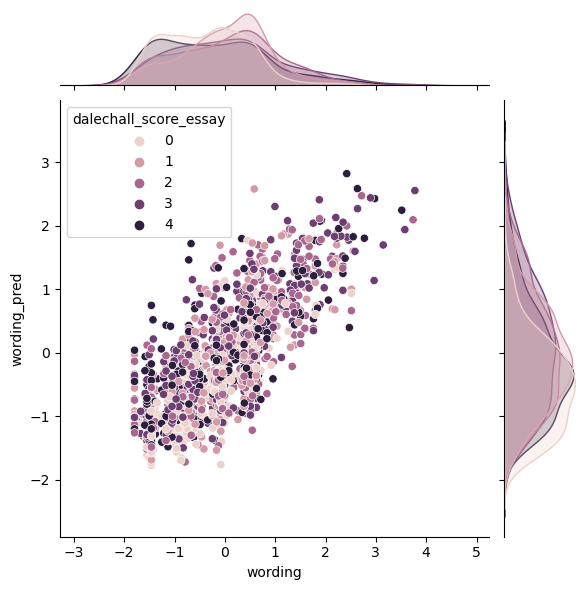

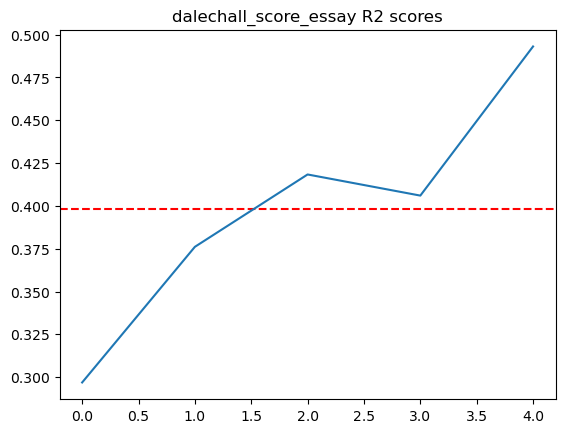

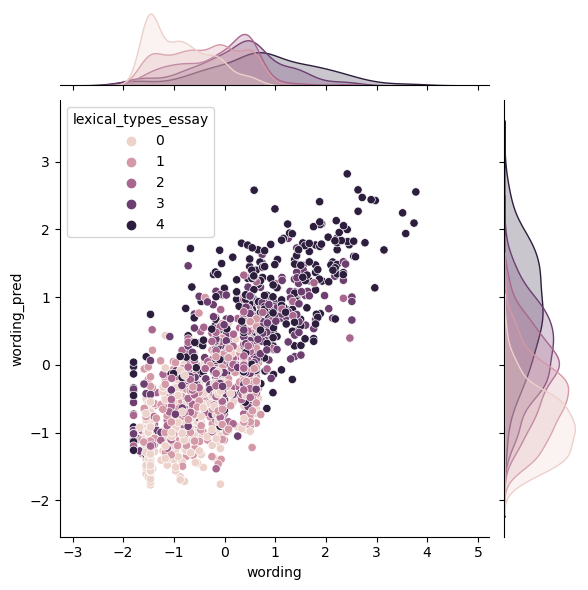

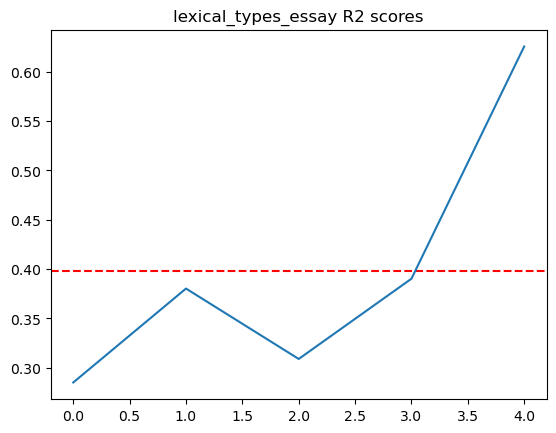

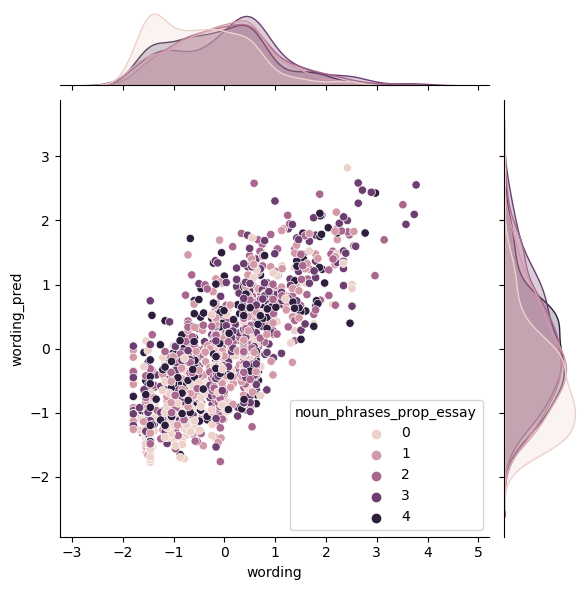

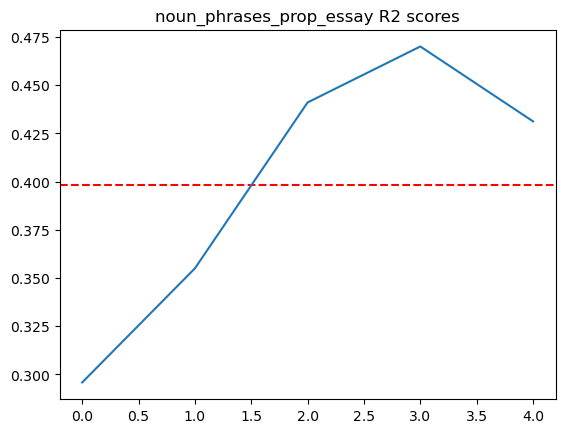

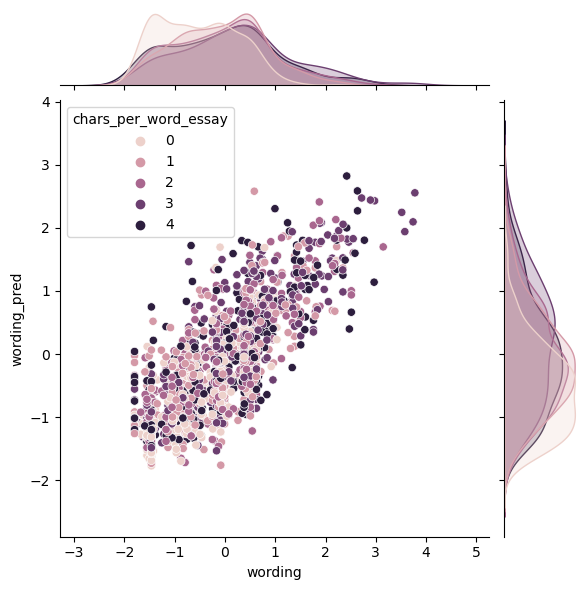

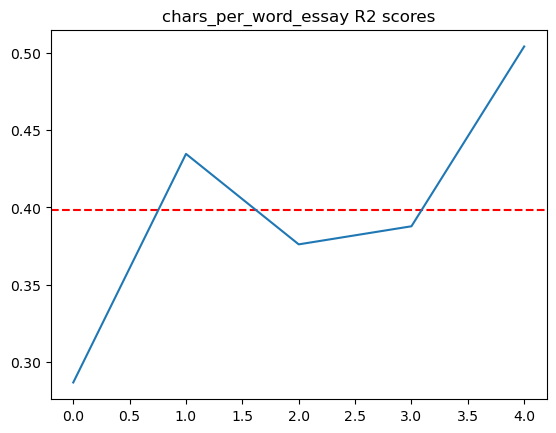

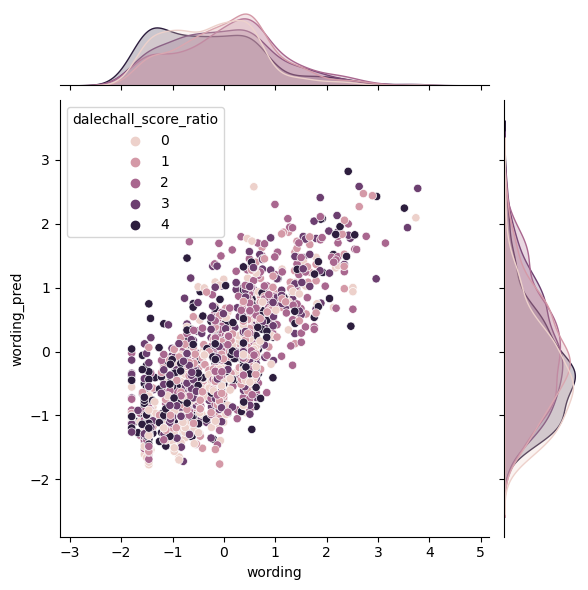

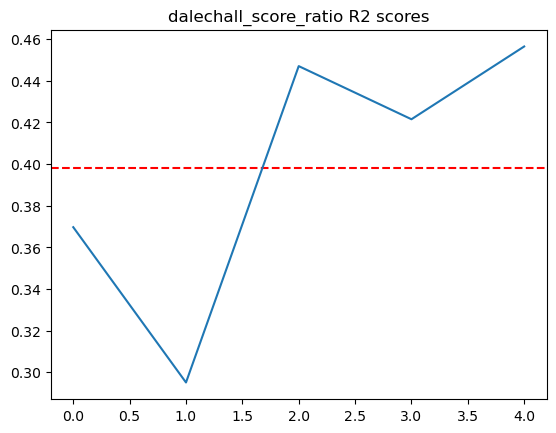

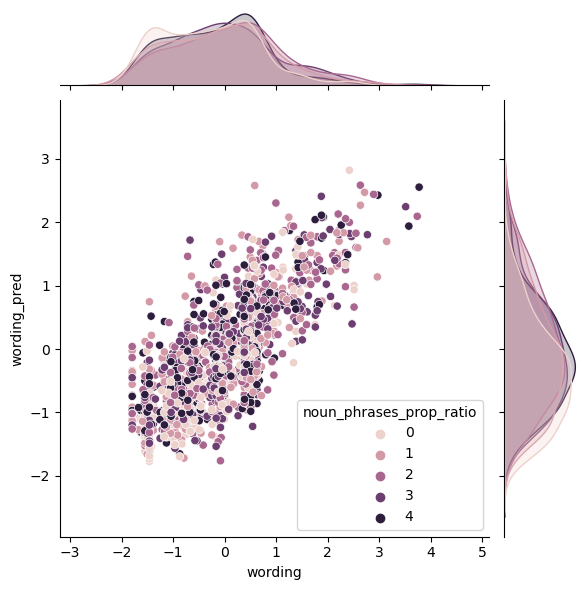

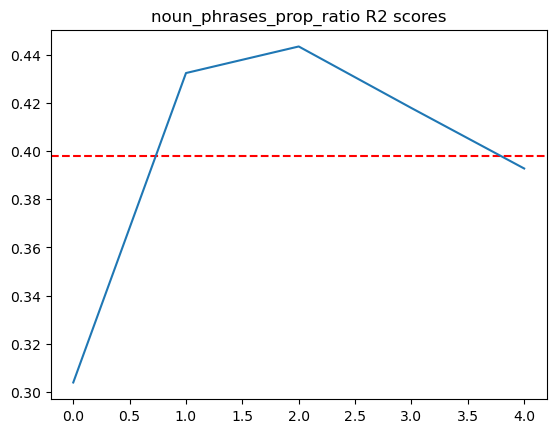

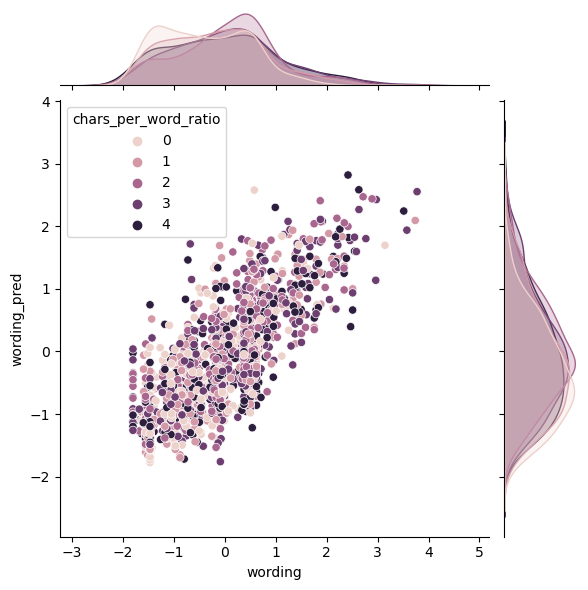

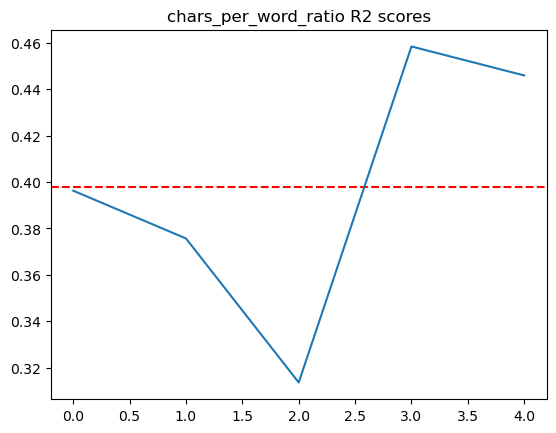

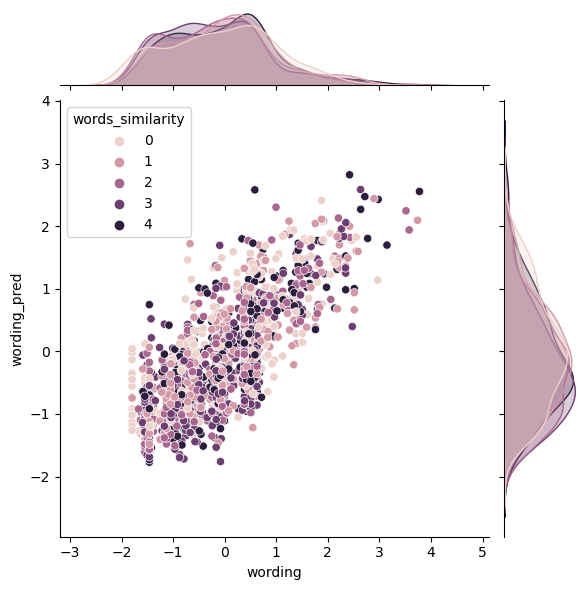

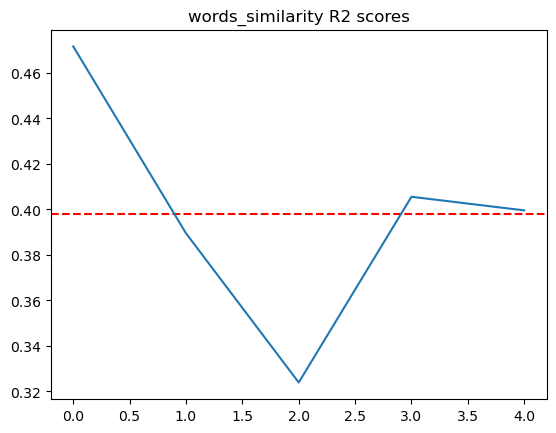

In [72]:
features_to_plot = [feature for feature, importance in wording_importances.items() if importance >= 120]
plot_predictions_features(df_val, features_to_plot, 'wording', 'wording_pred')